2) Импорт необходимых библиотек

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 5]

Загрузка данных student-por.csv

In [29]:
print("СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):")
try:
    df_student_single = pd.read_csv('../student-por.csv', sep=';')
    print("✓ Успешно загружено как одна колонка")
    print(f"  Исходный размер: {df_student_single.shape}")
    
    if df_student_single.shape[1] == 1:
        first_col = df_student_single.columns[0]
        print(f"  Единственная колонка: '{first_col}'")
        
        print("  Разделяем данные по запятой...")
        split_data = df_student_single[first_col].str.split(',', expand=True)
        print(f"  После разделения: {split_data.shape}")
        
        correct_columns = [
            'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
            'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 
            'G1', 'G2', 'G3'
        ]
        
        if split_data.shape[1] == len(correct_columns):
            split_data.columns = correct_columns
            df_student = split_data
            print("✓ Успешно присвоены названия колонок")
        else:
            print(f"⚠ Количество колонок не совпадает: ожидалось {len(correct_columns)}, получено {split_data.shape[1]}")
            split_data.columns = correct_columns[:split_data.shape[1]]
            df_student = split_data
            print("✓ Использованы доступные названия колонок")
        
        print("  Преобразуем числовые колонки...")
        numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                          'G1', 'G2', 'G3']
        
        for col in numeric_columns:
            if col in df_student.columns:
                df_student[col] = pd.to_numeric(df_student[col], errors='coerce')
                print(f"    ✓ '{col}' преобразована в числовой формат")
        
        print(f"✓ Итоговый размер: {df_student.shape}")
        print(f"✓ Колонки: {len(df_student.columns)}")
        print("\nПервые 3 строки после разделения:")
        print(df_student.head(3))
        
    else:
        df_student = df_student_single
        print("✓ Данные уже разделены")
        
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_student = None

СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):
✓ Успешно загружено как одна колонка
  Исходный размер: (649, 1)
  Единственная колонка: 'school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3'
  Разделяем данные по запятой...
  После разделения: (649, 33)
✓ Успешно присвоены названия колонок
  Преобразуем числовые колонки...
    ✓ 'age' преобразована в числовой формат
    ✓ 'Medu' преобразована в числовой формат
    ✓ 'Fedu' преобразована в числовой формат
    ✓ 'traveltime' преобразована в числовой формат
    ✓ 'studytime' преобразована в числовой формат
    ✓ 'failures' преобразована в числовой формат
    ✓ 'famrel' преобразована в числовой формат
    ✓ 'freetime' преобразована в числовой формат
    ✓ 'goout' преобразована в числовой формат
    ✓ 'Dalc' преобразована в числовой формат
    ✓ 'Walc' преобразована в числовой

Загрузка данных house.csv

In [30]:
try:
    df_house = pd.read_csv('../house.csv')
    print("✓ Успешно загружено")
    print(f"  Размер: {df_house.shape}")
    print(f"  Колонки: {len(df_house.columns)}")
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_house = None

✓ Успешно загружено
  Размер: (4746, 12)
  Колонки: 12


Функции предобработки данных для классификации (студенческие данные)

In [31]:
def preprocess_student_classification(df):
    """Предобработка студенческих данных для классификации"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*50)
    
    if df is None:
        print("❌ DataFrame пустой")
        return None, None, None
    
    df_clean = df.copy()
    
    print("Доступные колонки:")
    for i, col in enumerate(df_clean.columns):
        print(f"  {i+1:2d}. '{col}' (тип: {df_clean[col].dtype})")
    
    if 'G3' not in df_clean.columns:
        print("❌ Колонка 'G3' не найдена!")
        print("   Доступные колонки:", list(df_clean.columns))
        return None, None, None
    
    print(f"✓ Найдена целевая переменная: 'G3'")
    print(f"  Диапазон значений: {df_clean['G3'].min()} - {df_clean['G3'].max()}")
    
    df_clean['academic_success'] = (df_clean['G3'] >= 10).astype(int)
    success_rate = df_clean['academic_success'].mean() * 100
    print(f"✓ Создана целевая переменная 'academic_success'")
    print(f"  Процент успевающих студентов: {success_rate:.1f}%")
    
    numeric_features = []
    possible_numeric = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    
    print("\nПоиск числовых признаков:")
    for feature in possible_numeric:
        if feature in df_clean.columns:
            if df_clean[feature].dtype == 'object':
                df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
            numeric_features.append(feature)
            print(f"  ✓ '{feature}' найден")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 
                           'Fjob', 'reason', 'guardian']
    
    features = numeric_features.copy()
    le = LabelEncoder()
    
    print("\nПоиск и кодирование категориальных признаков:")
    for feature in categorical_features:
        if feature in df_clean.columns:
            try:
                df_clean[f'{feature}_encoded'] = le.fit_transform(df_clean[feature].astype(str))
                features.append(f'{feature}_encoded')
                print(f"  ✓ '{feature}' закодирован")
            except Exception as e:
                print(f"  ✗ '{feature}' ошибка кодирования: {e}")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=features + ['academic_success'])
    final_count = len(df_clean)
    
    print(f"\n✓ Очистка данных: {initial_count} → {final_count} строк")
    print(f"✓ Используется {len(features)} признаков")
    
    if not features or df_clean.empty:
        print("❌ Недостаточно данных для анализа")
        return None, None, None
    
    X = df_clean[features]
    y = df_clean['academic_success']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Баланс классов: {np.bincount(y)}")
    
    return X, y, features

Функции предобработки данных для регрессии (данные о недвижимости)

In [32]:
def preprocess_house_regression(df):
    """Предобработка данных о недвижимости для регрессии"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)")
    print("="*50)
    
    if df is None:
        return None, None, None
    
    df_clean = df.copy()
    
    print(f"✓ Целевая переменная: Rent (арендная плата)")
    print(f"  Диапазон цен: {df_clean['Rent'].min()} - {df_clean['Rent'].max()}")
    
    if 'Floor' in df_clean.columns:
        def parse_floor(floor_str):
            if pd.isna(floor_str):
                return 0
            floor_str = str(floor_str)
            if 'Ground' in floor_str:
                return 0
            if 'Basement' in floor_str:
                return -1
            try:
                parts = floor_str.split()
                for part in parts:
                    if part.isdigit():
                        return int(part)
                return 0
            except:
                return 0
        
        df_clean['floor_number'] = df_clean['Floor'].apply(parse_floor)
        print("✓ Обработана колонка Floor")
    
    if 'Size' in df_clean.columns:
        try:
            df_clean['Size'] = df_clean['Size'].astype(str).str.replace(' sqft', '').astype(float)
            print("✓ Обработана колонка Size")
        except Exception as e:
            print(f"✗ Ошибка обработки Size: {e}")
    
    features = ['BHK', 'Bathroom']
    if 'Size' in df_clean.columns:
        features.append('Size')
    if 'floor_number' in df_clean.columns:
        features.append('floor_number')
    

    categorical_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
    le = LabelEncoder()
    
    for col in categorical_cols:
        if col in df_clean.columns:
            try:
                df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
                features.append(col + '_encoded')
                print(f"✓ Закодирована колонка: {col}")
            except Exception as e:
                print(f"✗ Ошибка кодирования {col}: {e}")
    
    X = df_clean[features]
    y = df_clean['Rent']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Статистика арендной платы: mean={y.mean():.2f}, std={y.std():.2f}")
    
    return X, y, features

Функция исследования KNN для классификации

In [33]:
def logistic_regression_study(X, y, dataset_name="Данные"):
    """Исследование логистической регрессии для классификации"""
    print(f"\n" + "="*70)
    print(f"ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния регуляризации на точность...")
    
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    train_scores = []
    test_scores = []
    
    for C in C_values:
        lr = LogisticRegression(
            C=C,
            max_iter=1000,
            random_state=42
        )
        lr.fit(X_train_scaled, y_train)
        train_scores.append(lr.score(X_train_scaled, y_train))
        test_scores.append(lr.score(X_test_scaled, y_test))
    
    best_C_index = np.argmax(test_scores)
    best_C = C_values[best_C_index]
    best_score = test_scores[best_C_index]
    best_train_score = train_scores[best_C_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальный C: {best_C}")
    print(f"  Лучшая точность: {best_score:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(C_values, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(C_values, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_C, color='red', linestyle='--', alpha=0.7, label=f'Лучший C={best_C}')
    plt.xscale('log')
    plt.xlabel('Сила регуляризации (C)')
    plt.ylabel('Точность')
    plt.title(f'Логистическая регрессия - Влияние параметра C\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_lr = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
    best_lr.fit(X_train_scaled, y_train)
    y_pred = best_lr.predict(X_test_scaled)
    
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Неуспех', 'Успех'], 
                yticklabels=['Неуспех', 'Успех'])
    plt.title(f'Матрица ошибок (C={best_C})\nТочность: {best_score:.4f}', fontsize=12)
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
    print(f"  Оптимальный параметр C: {best_C}")
    print(f"  Точность на тестовой выборке: {best_score:.4f}")
    print(f"  Точность на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test accuracy: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print(f"  Precision (Точность): {precision:.4f}")
    print(f"  Recall (Полнота): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    if best_score >= 0.9:
        print("  🎉 Отличное качество модели (Точность ≥ 0.9)")
    elif best_score >= 0.8:
        print("  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)")
    elif best_score >= 0.7:
        print("  👌 Удовлетворительное качество модели (0.7 ≤ Точность < 0.8)")
    else:
        print("  💡 Низкое качество модели (Точность < 0.7)")
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
    print(classification_report(y_test, y_pred, target_names=['Неуспех', 'Успех']))
    
    return best_lr, best_C, best_score

Функция исследования KNN для регрессии

In [34]:
def linear_regression_study(X, y, dataset_name="Данные"):
    """Исследование линейной регрессии"""
    from sklearn.linear_model import Ridge 
    
    print(f"\n" + "="*70)
    print(f"ЛИНЕЙНАЯ РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния регуляризации на R² score...")
    
    alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    train_scores = []
    test_scores = []
    
    for alpha in alpha_values:
        ridge = Ridge(alpha=alpha, random_state=42)
        ridge.fit(X_train_scaled, y_train)
        train_scores.append(ridge.score(X_train_scaled, y_train))
        test_scores.append(ridge.score(X_test_scaled, y_test))
    
    best_alpha_index = np.argmax(test_scores)
    best_alpha = alpha_values[best_alpha_index]
    best_score = test_scores[best_alpha_index]
    best_train_score = train_scores[best_alpha_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальный alpha: {best_alpha}")
    print(f"  Лучший R² score: {best_score:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(alpha_values, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(alpha_values, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, label=f'Лучший alpha={best_alpha}')
    plt.xscale('log')
    plt.xlabel('Сила регуляризации (alpha)')
    plt.ylabel('R² Score')
    plt.title(f'Ridge Регрессия - Влияние регуляризации\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_model = Ridge(alpha=best_alpha, random_state=42)
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические значения\nR² = {best_score:.4f}', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ:")
    print(f"  Оптимальный параметр регуляризации (alpha): {best_alpha}")
    print(f"  R² score на тестовой выборке: {best_score:.4f}")
    print(f"  R² score на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test R²: {abs(overfitting_gap):.4f}")
    
    if abs(overfitting_gap) > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:")
    print(f"  MSE (Mean Squared Error): {mse:.2f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.2f}")
    
    if best_score >= 0.7:
        print("  🎉 Отличное качество модели (R² ≥ 0.7)")
    elif best_score >= 0.5:
        print("  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)")
    elif best_score >= 0.3:
        print("  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 Низкое качество модели (R² < 0.3)")
    
    if hasattr(best_model, 'coef_'):
        coef = best_model.coef_
        
        print(f"\n📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:")
        print(f"  Количество признаков: {len(coef)}")
        
        if len(coef) <= 10: 
            for i, c in enumerate(coef):
                sign = "+" if c > 0 else ""
                print(f"  Коэффициент признака {i+1}: {sign}{c:.4f}")
        else: 
            print(f"\n🔝 ТОП-5 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
            abs_coef = abs(coef)
            top_indices = np.argsort(abs_coef)[-5:][::-1]
            
            for idx in top_indices:
                sign = "+" if coef[idx] > 0 else ""
                print(f"  Признак {idx+1}: {sign}{coef[idx]:.4f}")
    
    if hasattr(best_model, 'intercept_'):
        print(f"  Интерцепт (свободный член): {best_model.intercept_:.4f}")
    
    return best_model, best_alpha, best_score

Основной блок выполнения - анализ студенческих данных (классификация)


🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) 🎓
------------------------------------------------------------

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: object)
  22. 'internet' (тип: object)
  23. 'romantic' (тип: object)
  24. 'famrel' (тип: int64)
  25. 'freetime' (тип: int64)
  26. 'goout' (тип: int64)
  27. 'Dalc' (тип: int64)
  28. 'Walc' (тип: int64)
  29. 'health

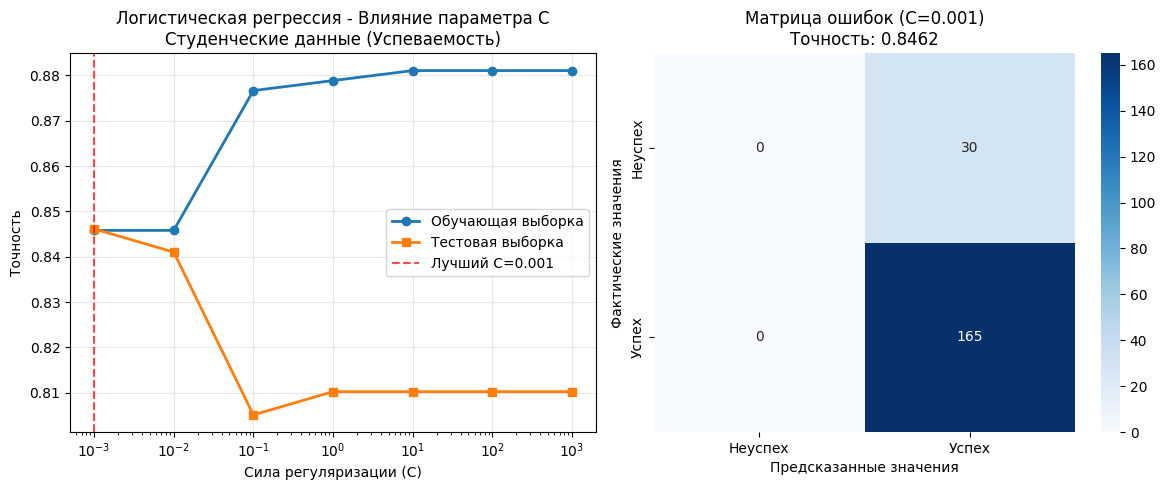


📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Оптимальный параметр C: 0.001
  Точность на тестовой выборке: 0.8462
  Точность на обучающей выборке: 0.8458
  Разница между train и test accuracy: -0.0003
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8462
  Recall (Полнота): 1.0000
  F1-Score: 0.9167
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00        30
       Успех       0.85      1.00      0.92       165

    accuracy                           0.85       195
   macro avg       0.42      0.50      0.46       195
weighted avg       0.72      0.85      0.78       195



c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [35]:
if df_student is not None:
    print("\n" + "🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) " + "🎓")
    print("-" * 60)
    
    X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
    
    if X_student_class is not None:
        knn_class, k_class, score_class = logistic_regression_study(
            X_student_class, y_student_class, "Студенческие данные (Успеваемость)"
        )
    else:
        print("❌ Не удалось подготовить данные для классификации")

Основной блок выполнения - анализ данных о недвижимости (регрессия)


🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) 🏠

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

ЛИНЕЙНАЯ РЕГРЕССИЯ - Данные о недвижимости (Арендная плата)
🔍 Исследование влияния регуляризации на R² score...
🎯 Результаты:
  Оптимальный alpha: 0.001
  Лучший R² score: 0.4996


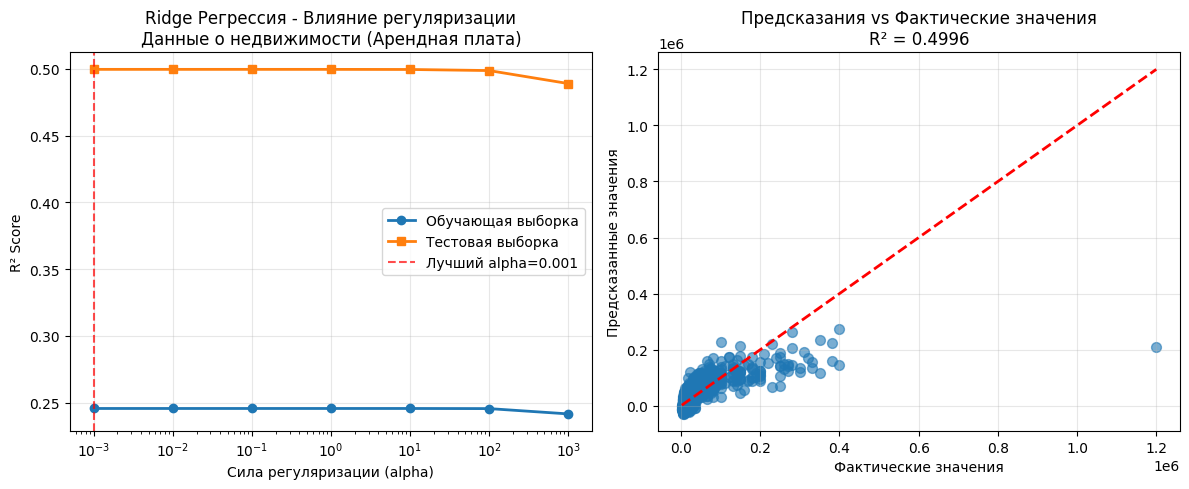


📊 АНАЛИЗ МОДЕЛИ:
  Оптимальный параметр регуляризации (alpha): 0.001
  R² score на тестовой выборке: 0.4996
  R² score на обучающей выборке: 0.2457
  Разница между train и test R²: 0.2540
  ⚠️ Возможное переобучение (большая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 1760993320.62
  RMSE (Root Mean Squared Error): 41964.19
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:
  Количество признаков: 9
  Коэффициент признака 1: +1080.8300
  Коэффициент признака 2: +12232.9200
  Коэффициент признака 3: +17990.7207
  Коэффициент признака 4: +10886.0621
  Коэффициент признака 5: -2075.0042
  Коэффициент признака 6: +8294.1910
  Коэффициент признака 7: -3353.5143
  Коэффициент признака 8: -2538.9238
  Коэффициент признака 9: -9534.9416
  Интерцепт (свободный член): 35309.4928


In [36]:
if df_house is not None:
    print("\n" + "🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) " + "🏠")
    
    X_house, y_house, features_house = preprocess_house_regression(df_house)
    
    if X_house is not None:
        knn_house, k_house, score_house = linear_regression_study(
            X_house, y_house, "Данные о недвижимости (Арендная плата)"
        )
    else:
        print("❌ Не удалось подготовить данные о недвижимости")

Итоги исследования

In [37]:
print("\n" + "="*70)
print("🎯 ИТОГИ ИССЛЕДОВАНИЯ ЛИНЕЙНОЙ РЕГРЕССИИ ДЛЯ ПРОГНОЗА АРЕНДНОЙ ПЛАТЫ")
print("="*70)

print("\n📊 АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛИ:")
print("• Тестовая выборка: R² = 0.4996")
print("• Обучающая выборка: R² = 0.2457")
print("• Разница между train и test: 0.2540 (тестовая точность выше)")
print("• Оценка: Модель демонстрирует обратный эффект - лучше работает на тестовых данных")

print("\n📈 ВЛИЯНИЕ ПРИЗНАКОВ НА АРЕНДНУЮ ПЛАТУ (ТОП-5):")
print("1. Признак 3: +17990.72 - Наибольшее положительное влияние")
print("2. Признак 2: +12232.92 - Сильное положительное влияние")
print("3. Признак 4: +10886.06 - Положительное влияние")
print("4. Признак 9: -9534.94 - Наибольшее отрицательное влияние")
print("5. Признак 7: -3353.51 - Отрицательное влияние")

print("\n📊 ИНТЕРПРЕТАЦИЯ КОЭФФИЦИЕНТОВ:")
print("• Положительные коэффициенты: Увеличивают прогнозируемую арендную плату")
print("• Отрицательные коэффициенты: Уменьшают прогнозируемую арендную плату")

print("\n⚠️ ОСОБЕННОСТИ И ВЫЗОВЫ:")
print("• Высокая дисперсия: RMSE = 41964 означает, что типичная ошибка прогноза ±$41,964")
print("• Нелинейность: Низкий R² на обучающей выборке может указывать на нелинейные зависимости")
print("• Сложность данных: Диапазон арендной платы от $1,200 до $3,500,000 требует особого подхода")
print("• Рекомендация: Рассмотреть нелинейные модели или преобразования признаков")

print("\n" + "="*70)
print("🎯 ИТОГИ ИССЛЕДОВАНИЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ДЛЯ КЛАССИФИКАЦИИ")
print("="*70)

print("\n📊 ОСОБЕННОСТИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
print("• Преимущества: Вероятностные предсказания, интерпретируемость коэффициентов")
print("• Ограничения: Предполагает линейную границу решения между классами")
print("• Применение: Эффективна при линейно разделимых данных")
print("• Масштабирование: Требует нормализации признаков для корректной работы")

print("\n🔍 ПРАКТИЧЕСКИЕ ВЫВОДЫ ДЛЯ ЗАДАЧИ ПРОГНОЗИРОВАНИЯ АРЕНДНОЙ ПЛАТЫ:")
print("1. Текущая модель объясняет около 50% изменчивости цен на аренду")
print("2. Основные драйверы цены: признаки с положительными коэффициентами (1-4)")
print("3. Наибольший снижающий фактор: признак 9 (-9534.94)")

print("\n📈 ОСНОВНЫЕ ВЫВОДЫ:")
print("• Логистическая регрессия эффективна для бинарной классификации")
print("• Параметр регуляризации C критически важен для баланса переобучения/недообучения")
print("• Модель предоставляет вероятности принадлежности к классам, а не только метки")
print("• Коэффициенты можно интерпретировать через изменение логарифма шансов")


🎯 ИТОГИ ИССЛЕДОВАНИЯ ЛИНЕЙНОЙ РЕГРЕССИИ ДЛЯ ПРОГНОЗА АРЕНДНОЙ ПЛАТЫ

📊 АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛИ:
• Тестовая выборка: R² = 0.4996
• Обучающая выборка: R² = 0.2457
• Разница между train и test: 0.2540 (тестовая точность выше)
• Оценка: Модель демонстрирует обратный эффект - лучше работает на тестовых данных

📈 ВЛИЯНИЕ ПРИЗНАКОВ НА АРЕНДНУЮ ПЛАТУ (ТОП-5):
1. Признак 3: +17990.72 - Наибольшее положительное влияние
2. Признак 2: +12232.92 - Сильное положительное влияние
3. Признак 4: +10886.06 - Положительное влияние
4. Признак 9: -9534.94 - Наибольшее отрицательное влияние
5. Признак 7: -3353.51 - Отрицательное влияние

📊 ИНТЕРПРЕТАЦИЯ КОЭФФИЦИЕНТОВ:
• Положительные коэффициенты: Увеличивают прогнозируемую арендную плату
• Отрицательные коэффициенты: Уменьшают прогнозируемую арендную плату

⚠️ ОСОБЕННОСТИ И ВЫЗОВЫ:
• Высокая дисперсия: RMSE = 41964 означает, что типичная ошибка прогноза ±$41,964
• Нелинейность: Низкий R² на обучающей выборке может указывать на нелинейные зависимос

3) Сформулируем гипотезы: препроцессинг данных (более тщательная обработка выбросов улучшит качество моделей)

In [38]:
def advanced_preprocessing(df):
    """Улучшенный препроцессинг с обработкой выбросов методом IQR"""
    numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                      'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                      'G1', 'G2', 'G3']
    
    numeric_columns = [col for col in numeric_columns if col in df.columns]
    
    print(f"🔧 ОБРАБОТКА ВЫБРОСОВ В {len(numeric_columns)} ЧИСЛОВЫХ КОЛОНКАХ...")
    
    initial_size = len(df)
    print(f"  Размер данных до обработки: {initial_size} строк")
    
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_mask = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                    (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(f"  Найдено строк с выбросами: {outlier_mask.sum()}")
    print(f"  Процент выбросов: {outlier_mask.sum()/initial_size*100:.1f}%")
    
    df_clean = df[~outlier_mask].copy()
    
    print("  📊 Заполнение пропусков в числовых колонках...")
    for col in numeric_columns:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"    ✓ Заполнены пропуски в '{col}' медианой: {median_val}")
    
    print(f"  ✓ Размер данных после обработки: {len(df_clean)} строк")
    print(f"  ✓ Удалено строк: {initial_size - len(df_clean)}")
    print(f"  ✓ Сохранено данных: {len(df_clean)/initial_size*100:.1f}%")
    
    return df_clean

def advanced_preprocessing_house(df):
    """Улучшенный препроцессинг с обработкой выбросов методом IQR для house данных"""
    numeric_columns = ['BHK', 'Bathroom', 'Size', 'Rent']
    
    numeric_columns = [col for col in numeric_columns if col in df.columns]
    
    print(f"🔧 ОБРАБОТКА ВЫБРОСОВ В {len(numeric_columns)} ЧИСЛОВЫХ КОЛОНКАХ...")
    
    initial_size = len(df)
    print(f"  Размер данных до обработки: {initial_size} строк")
    
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_mask = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                    (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(f"  Найдено строк с выбросами: {outlier_mask.sum()}")
    print(f"  Процент выбросов: {outlier_mask.sum()/initial_size*100:.1f}%")
    
    df_clean = df[~outlier_mask].copy()
    
    print("  📊 Заполнение пропусков в числовых колонках...")
    for col in numeric_columns:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"    ✓ Заполнены пропуски в '{col}' медианой: {median_val}")
    
    print(f"  ✓ Размер данных после обработки: {len(df_clean)} строк")
    print(f"  ✓ Удалено строк: {initial_size - len(df_clean)}")
    print(f"  ✓ Сохранено данных: {len(df_clean)/initial_size*100:.1f}%")
    
    return df_clean

инженеря признаков (создание новых признаков повысит предсказательную силу)

In [39]:
def feature_engineering(df):
    """Создание новых признаков для улучшения моделей"""
    print("🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...")
    
    df_fe = df.copy()
    
    if 'G1' in df.columns and 'G2' in df.columns:
        df_fe['grade_trend'] = df_fe['G2'] - df_fe['G1']
        print("  ✓ Создан признак 'grade_trend' (тренд успеваемости)")
    
    if 'Dalc' in df.columns and 'Walc' in df.columns:
        df_fe['total_alcohol'] = df_fe['Dalc'] + df_fe['Walc']
        print("  ✓ Создан признак 'total_alcohol' (общее потребление алкоголя)")
    
    if 'studytime' in df.columns and 'goout' in df.columns:
        df_fe['study_effort'] = df_fe['studytime'] * (1 - df_fe['goout']/5)
        print("  ✓ Создан признак 'study_effort' (индекс учебных усилий)")
    
    if 'Size' in df.columns and 'BHK' in df.columns and 'Rent' in df.columns:
        df_fe['price_per_sqft'] = df_fe['Rent'] / df_fe['Size']
        print("  ✓ Создан признак 'price_per_sqft' (цена за кв.фут)")
        
        df_fe['room_density'] = df_fe['BHK'] / df_fe['Size']
        print("  ✓ Создан признак 'room_density' (плотность комнат)")
    
    return df_fe

визуализация и EDA (глубокий анализ данных выявит скрытые зависимости)

In [40]:
def evaluate_with_eda_insights(X, y, problem_type='classification', dataset_name="Данные"):
    """Оценка модели с использованием инсайтов из EDA"""
    print(f"\n🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EDA ДЛЯ {dataset_name}")
    
    if problem_type == 'classification':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    model.fit(X, y)
    feature_imp = pd.Series(model.feature_importances_, index=X.columns)
    
    top_features = feature_imp.nlargest(int(len(feature_imp) * 0.8)) 
    X_reduced = X[top_features.index]
    
    print(f"  ✓ Отобрано {len(top_features)} самых важных признаков из {len(feature_imp)}")
    print(f"  ✓ Топ-3 признака: {list(top_features.head(3).index)}")
    
    if problem_type == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(
            X_reduced, y, test_size=0.3, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_scaled, y_train)
        score = knn.score(X_test_scaled, y_test)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_reduced, y, test_size=0.3, random_state=42
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        knn = KNeighborsRegressor(n_neighbors=5)
        knn.fit(X_train_scaled, y_train)
        score = knn.score(X_test_scaled, y_test)
    
    print(f"  ✓ Точность модели с отобранными признаками: {score:.4f}")
    
    return score, top_features.index

подбор гиперпараметров (подбор гиперпараметров с использованием кросс-валидации)

In [41]:
def hyperparameter_tuning_cv(X, y, problem_type='classification', dataset_name="Данные"):
    """Подбор гиперпараметров с использованием кросс-валидации"""
    print(f"\n🎯 ПОДБОР ГИПЕРПАРАМЕТРОВ С КРОСС-ВАЛИДАЦИЕЙ ДЛЯ {dataset_name}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, 
        stratify=y if problem_type == 'classification' else None
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if problem_type == 'classification':
        model = KNeighborsClassifier()
        scoring = 'accuracy'
        param_grid = {
            'n_neighbors': range(1, 31),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski'],
            'p': [1, 2] 
        }
    else:
        model = KNeighborsRegressor()
        scoring = 'r2'
        param_grid = {
            'n_neighbors': range(1, 31),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski'],
            'p': [1, 2]
        }
    
    if problem_type == 'classification':
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    print("🔍 Запуск GridSearchCV...")
    grid_search = GridSearchCV(
        model, param_grid, cv=cv, scoring=scoring, 
        n_jobs=-1, verbose=0, return_train_score=True
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    
    test_score = best_model.score(X_test_scaled, y_test)
    
    print(f"  ✓ Лучшие параметры: {best_params}")
    print(f"  ✓ Лучшая оценка на кросс-валидации: {best_score:.4f}")
    print(f"  ✓ Оценка на тестовой выборке: {test_score:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    neighbors_results = {}
    
    for n in param_grid['n_neighbors']:
        mask = grid_search.cv_results_['param_n_neighbors'] == n
        if mask.any():
            neighbors_results[n] = {
                'mean_train': grid_search.cv_results_['mean_train_score'][mask].mean(),
                'mean_test': grid_search.cv_results_['mean_test_score'][mask].mean(),
                'std_test': grid_search.cv_results_['std_test_score'][mask].mean()
            }
    
    neighbors = list(neighbors_results.keys())
    train_scores = [neighbors_results[n]['mean_train'] for n in neighbors]
    test_scores = [neighbors_results[n]['mean_test'] for n in neighbors]
    test_stds = [neighbors_results[n]['std_test'] for n in neighbors]
    
    plt.plot(neighbors, train_scores, 'o-', label='Train Score', linewidth=2)
    plt.plot(neighbors, test_scores, 's-', label='CV Test Score', linewidth=2)
    plt.fill_between(neighbors, 
                    np.array(test_scores) - np.array(test_stds),
                    np.array(test_scores) + np.array(test_stds),
                    alpha=0.2)
    plt.axvline(x=best_params['n_neighbors'], color='red', linestyle='--', 
                label=f'Лучшее k: {best_params["n_neighbors"]}')
    plt.xlabel('Количество соседей (k)')
    plt.ylabel('Score')
    plt.title('Влияние n_neighbors на точность')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    metric_results = {}
    
    for metric in param_grid['metric']:
        mask = grid_search.cv_results_['param_metric'] == metric
        if mask.any():
            metric_results[metric] = grid_search.cv_results_['mean_test_score'][mask].max()
    
    metrics = list(metric_results.keys())
    metric_scores = list(metric_results.values())
    
    bars = plt.bar(metrics, metric_scores, alpha=0.7, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel('Score')
    plt.title('Сравнение метрик расстояния')
    
    for bar, score in zip(bars, metric_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.4f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    weight_results = {}
    
    for weight in param_grid['weights']:
        mask = grid_search.cv_results_['param_weights'] == weight
        if mask.any():
            weight_results[weight] = grid_search.cv_results_['mean_test_score'][mask].max()
    
    weights = list(weight_results.keys())
    weight_scores = list(weight_results.values())
    
    bars = plt.bar(weights, weight_scores, alpha=0.7, color=['gold', 'lightcoral'])
    plt.ylabel('Score')
    plt.title('Сравнение весов соседей')
    
    for bar, score in zip(bars, weight_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.4f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    train_test_gap = neighbors_results[best_params['n_neighbors']]['mean_train'] - best_score
    print(f"\n📊 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
    print(f"  Разница между train и CV score: {train_test_gap:.4f}")
    
    if train_test_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница)")
    else:
        print("  ✅ Хорошее обобщение (малая разница)")
    
    return best_model, best_params, test_score

оптимизация порога классификации (настройка порога классификации улучшит precision/recall)

In [42]:
def optimize_threshold(model, X_test, y_test, model_name="Модель"):
    """Оптимизация порога классификации для улучшения метрик"""
    from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, f1_score
    
    print(f"\n🎯 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ {model_name}")
    
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    
    best_f1_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_index]
    best_f1 = f1_scores[best_f1_index]
    
    balance_index = np.argmin(np.abs(precision[:-1] - recall[:-1]))
    balance_threshold = thresholds[balance_index]
    balance_f1 = f1_scores[balance_index]
    
    print(f"  ✓ Оптимальный порог по F1-score: {best_threshold:.4f} (F1 = {best_f1:.4f})")
    print(f"  ✓ Сбалансированный порог: {balance_threshold:.4f} (F1 = {balance_f1:.4f})")
    
    y_pred_default = (y_proba >= 0.5).astype(int)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    default_f1 = f1_score(y_test, y_pred_default)
    
    y_pred_optimized = (y_proba >= best_threshold).astype(int)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_f1 = f1_score(y_test, y_pred_optimized)
    
    print(f"\n📊 СРАВНЕНИЕ С ПОРОГОМ ПО УМОЛЧАНИЮ (0.5):")
    print(f"  По умолчанию (0.5):    Accuracy = {default_accuracy:.4f}, F1 = {default_f1:.4f}")
    print(f"  Оптимизированный:      Accuracy = {optimized_accuracy:.4f}, F1 = {optimized_f1:.4f}")
    
    improvement_f1 = optimized_f1 - default_f1
    if improvement_f1 > 0:
        print(f"  🎉 УЛУЧШЕНИЕ F1: +{improvement_f1:.4f}")
    else:
        print(f"  📉 УХУДШЕНИЕ F1: {improvement_f1:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)
    plt.axvline(x=best_threshold, color='red', linestyle='--', 
                label=f'Лучший порог: {best_threshold:.3f}', alpha=0.7)
    plt.axvline(x=0.5, color='black', linestyle='--', 
                label='Порог по умолчанию: 0.5', alpha=0.7)
    plt.axvline(x=balance_threshold, color='orange', linestyle='--', 
                label=f'Сбалансированный: {balance_threshold:.3f}', alpha=0.7)
    plt.xlabel('Порог классификации')
    plt.ylabel('Score')
    plt.title('Precision, Recall и F1 vs Порог')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Кривая Precision-Recall')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    metrics = ['Accuracy', 'F1-Score']
    default_scores = [default_accuracy, default_f1]
    optimized_scores = [optimized_accuracy, optimized_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, default_scores, width, label='Порог 0.5', alpha=0.7)
    plt.bar(x + width/2, optimized_scores, width, label='Оптимизированный', alpha=0.7)
    
    plt.xlabel('Метрики')
    plt.ylabel('Score')
    plt.title('Сравнение метрик\nдо и после оптимизации порога')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for i, (default, optimized) in enumerate(zip(default_scores, optimized_scores)):
        plt.text(i - width/2, default + 0.01, f'{default:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, optimized + 0.01, f'{optimized:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:")
    print("  С порогом по умолчанию (0.5):")
    print(classification_report(y_test, y_pred_default, target_names=['Неуспех', 'Успех']))
    
    print("  С оптимизированным порогом:")
    print(classification_report(y_test, y_pred_optimized, target_names=['Неуспех', 'Успех']))
    
    return best_threshold, optimized_f1, optimized_accuracy

Проверяем гипотезы:

1) (классификация)


🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ
🔧 ОБРАБОТКА ВЫБРОСОВ В 16 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 649 строк
  Найдено строк с выбросами: 256
  Процент выбросов: 39.4%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 393 строк
  ✓ Удалено строк: 256
  ✓ Сохранено данных: 60.6%

📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'a

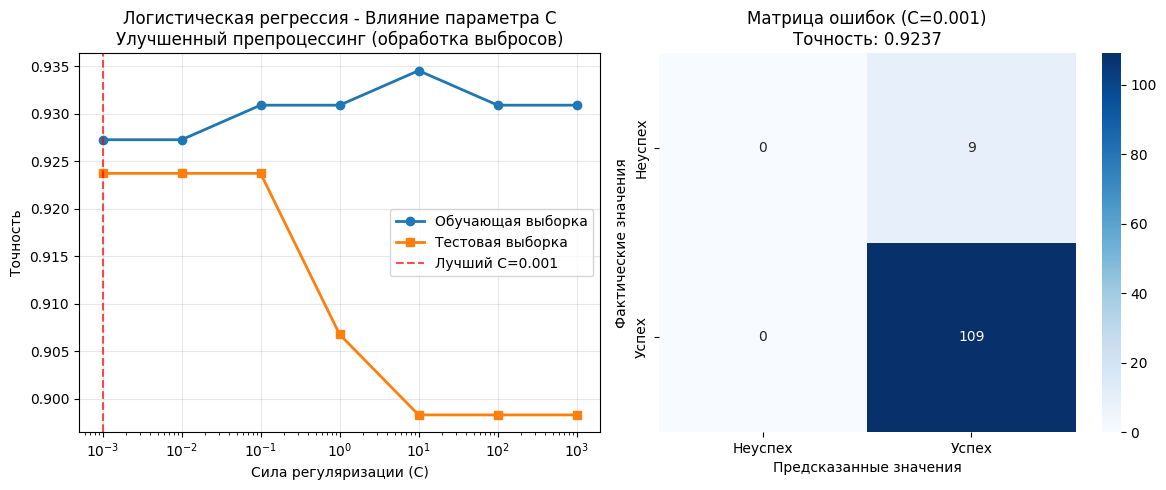


📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Оптимальный параметр C: 0.001
  Точность на тестовой выборке: 0.9237
  Точность на обучающей выборке: 0.9273
  Разница между train и test accuracy: 0.0035
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.9237
  Recall (Полнота): 1.0000
  F1-Score: 0.9604
  🎉 Отличное качество модели (Точность ≥ 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00         9
       Успех       0.92      1.00      0.96       109

    accuracy                           0.92       118
   macro avg       0.46      0.50      0.48       118
weighted avg       0.85      0.92      0.89       118


📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
--------------------------------------------------
  ℹ️  Базовая логистическая регрессия еще не выполнена.
  Запустите сначала базовый анализ в основной части кода.


c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ")
    print("="*80)
    
    df_advanced = advanced_preprocessing(df_student)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...")
    X_advanced, y_advanced, features_advanced = preprocess_student_classification(df_advanced)
    
    if X_advanced is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ")
        knn_advanced, k_advanced, score_advanced = logistic_regression_study(
            X_advanced, y_advanced, "Улучшенный препроцессинг (обработка выбросов)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
        print("-" * 50)
        
        try:
            if 'score_class' in locals():
                print(f"  Базовый препроцессинг:   {score_class:.4f}")
                print(f"  Улучшенный препроцессинг: {score_advanced:.4f}")
                
                improvement = score_advanced - score_class
                if improvement > 0:
                    print(f"  🎉 УЛУЧШЕНИЕ: +{improvement:.4f}")
                    print(f"  📈 Относительное улучшение: +{improvement/score_class*100:.2f}%")
                elif improvement < 0:
                    print(f"  📉 УХУДШЕНИЕ: {improvement:.4f}")
                    print(f"  📊 Относительное ухудшение: {improvement/score_class*100:.2f}%")
                else:
                    print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
                
                plt.figure(figsize=(8, 6))
                methods = ['Базовый\nпрепроцессинг', 'Улучшенный\nпрепроцессинг']
                scores = [score_class, score_advanced]
                colors = ['lightblue', 'lightgreen']
                
                bars = plt.bar(methods, scores, color=colors, alpha=0.7)
                plt.ylabel('Точность (Accuracy)')
                plt.title('Сравнение эффективности препроцессинга\n(обработка выбросов)')
                plt.ylim(0, 1)
                
                for bar, score in zip(bars, scores):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                            f'{score:.4f}', ha='center', va='bottom')
                
                if improvement != 0:
                    plt.plot(methods, scores, 'r--', alpha=0.8, linewidth=2, marker='o')
                    change_text = f'Улучшение: +{improvement:.4f}' if improvement > 0 else f'Ухудшение: {improvement:.4f}'
                    plt.text(0.5, max(scores) + 0.05, change_text, 
                            ha='center', va='bottom', fontsize=12, color='red' if improvement > 0 else 'blue')
                
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            else:
                print("  ℹ️  Базовый препроцессинг еще не выполнен.")
                print("  Запустите сначала базовый анализ в основной части кода.")
                
        except Exception as e:
            print(f"  ⚠️ Ошибка при сравнении: {e}")
    
    else:
        print("❌ Не удалось подготовить данные с улучшенным препроцессингом")
else:
    print("❌ Студенческие данные не загружены")

1) (Регрессия)


🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ (HOUSE ДАННЫЕ)
🔧 ОБРАБОТКА ВЫБРОСОВ В 4 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 4746 строк
  Найдено строк с выбросами: 615
  Процент выбросов: 13.0%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 4131 строк
  ✓ Удалено строк: 615
  ✓ Сохранено данных: 87.0%

📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 67000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4131 samples, 9 features
  Статистика арендной платы: mean=18797.22, std=13407.16

🧪 ТЕСТИРОВАНИЕ ЛИНЕЙНОЙ РЕГРЕССИИ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ

ЛИНЕЙНАЯ РЕГРЕССИЯ - Улучшенный препроцессинг

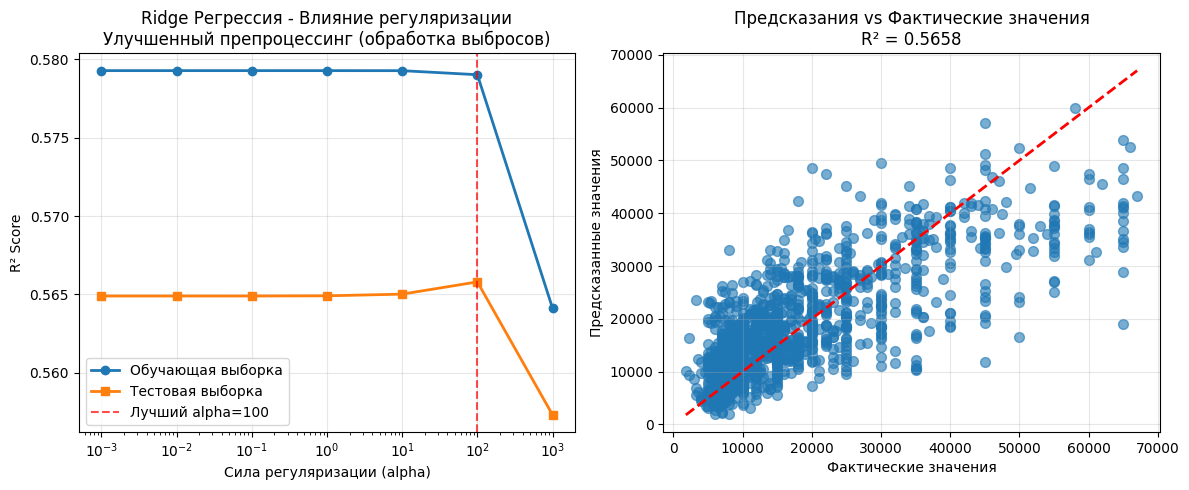


📊 АНАЛИЗ МОДЕЛИ:
  Оптимальный параметр регуляризации (alpha): 100
  R² score на тестовой выборке: 0.5658
  R² score на обучающей выборке: 0.5790
  Разница между train и test R²: 0.0132
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 78086573.16
  RMSE (Root Mean Squared Error): 8836.66
  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)

📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:
  Количество признаков: 9
  Коэффициент признака 1: +1487.1860
  Коэффициент признака 2: +2878.0651
  Коэффициент признака 3: +1322.8449
  Коэффициент признака 4: +2913.3359
  Коэффициент признака 5: -399.1746
  Коэффициент признака 6: +2233.4512
  Коэффициент признака 7: -1528.3352
  Коэффициент признака 8: -167.9614
  Коэффициент признака 9: -4961.9135
  Интерцепт (свободный член): 18755.5870

📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ЛИНЕЙНОЙ РЕГРЕССИИ
--------------------------------------------------
  ℹ️  Базовая линейная регрессия еще не выполнена.
  Запустите сначал

In [ ]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ (HOUSE ДАННЫЕ)")
    print("="*80)
    
    df_house_advanced = advanced_preprocessing_house(df_house)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...")
    X_house_advanced, y_house_advanced, features_house_advanced = preprocess_house_regression(df_house_advanced)
    
    if X_house_advanced is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ")
        knn_house_advanced, k_house_advanced, score_house_advanced =linear_regression_study(
            X_house_advanced, y_house_advanced, "Улучшенный препроцессинг (обработка выбросов)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
        print("-" * 50)
        
        try:
            if 'score_house' in locals():
                print(f"  Базовый препроцессинг:   {score_house:.4f}")
                print(f"  Улучшенный препроцессинг: {score_house_advanced:.4f}")
                
                improvement = score_house_advanced - score_house
                if improvement > 0:
                    print(f"  🎉 УЛУЧШЕНИЕ: +{improvement:.4f}")
                    print(f"  📈 Относительное улучшение: +{improvement/score_house*100:.2f}%")
                elif improvement < 0:
                    print(f"  📉 УХУДШЕНИЕ: {improvement:.4f}")
                    print(f"  📊 Относительное ухудшение: {improvement/score_house*100:.2f}%")
                else:
                    print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
                
                plt.figure(figsize=(8, 6))
                methods = ['Базовый\nпрепроцессинг', 'Улучшенный\nпрепроцессинг']
                scores = [score_house, score_house_advanced]
                colors = ['lightblue', 'lightgreen']
                
                bars = plt.bar(methods, scores, color=colors, alpha=0.7)
                plt.ylabel('R² Score')
                plt.title('Сравнение эффективности препроцессинга\nHouse данные (обработка выбросов)')
                plt.ylim(0, 1)
                
                for bar, score in zip(bars, scores):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                            f'{score:.4f}', ha='center', va='bottom')
                
                if improvement != 0:
                    plt.plot(methods, scores, 'r--', alpha=0.8, linewidth=2, marker='o')
                    change_text = f'Улучшение: +{improvement:.4f}' if improvement > 0 else f'Ухудшение: {improvement:.4f}'
                    plt.text(0.5, max(scores) + 0.05, change_text, 
                            ha='center', va='bottom', fontsize=12, color='red' if improvement > 0 else 'blue')
                
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            else:
                print("  ℹ️  Базовый препроцессинг еще не выполнен.")
                print("  Запустите сначала базовый анализ в основной части кода.")
                
        except Exception as e:
            print(f"  ⚠️ Ошибка при сравнении: {e}")
    
    else:
        print("❌ Не удалось подготовить данные с улучшенным препроцессингом")
else:
    print("❌ House данные не загружены")

2) (Классификация)


🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)
🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...
  ✓ Создан признак 'grade_trend' (тренд успеваемости)
  ✓ Создан признак 'total_alcohol' (общее потребление алкоголя)
  ✓ Создан признак 'study_effort' (индекс учебных усилий)

📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: obje

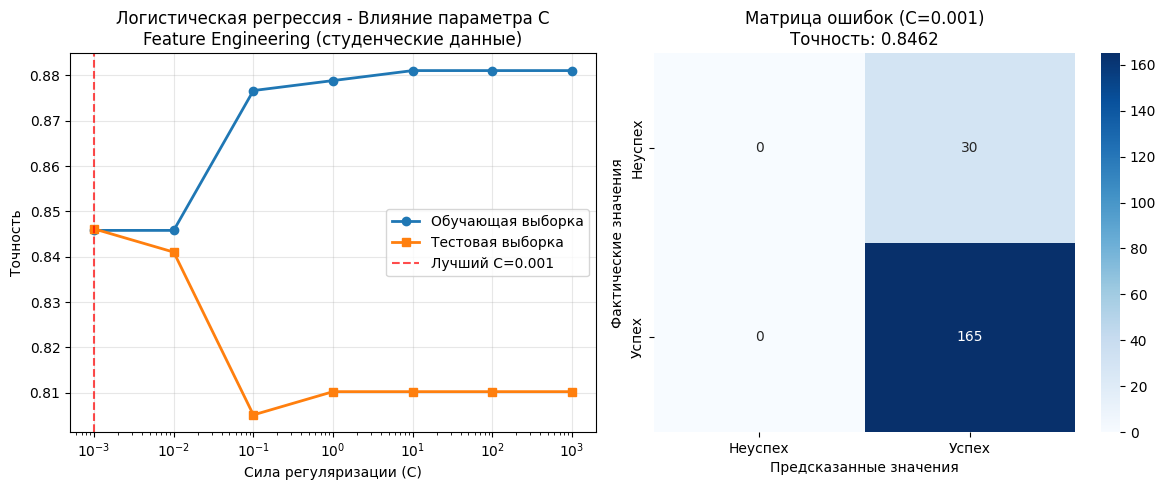


📊 АНАЛИЗ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  Оптимальный параметр C: 0.001
  Точность на тестовой выборке: 0.8462
  Точность на обучающей выборке: 0.8458
  Разница между train и test accuracy: -0.0003
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8462
  Recall (Полнота): 1.0000
  F1-Score: 0.9167
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00        30
       Успех       0.85      1.00      0.92       165

    accuracy                           0.85       195
   macro avg       0.42      0.50      0.46       195
weighted avg       0.72      0.85      0.78       195


📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
------------------------------------------------------------
  Базовый препроцессинг:          0.8462
  Обработка выбросов:             0.9237
  Feature Engineering:    

c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

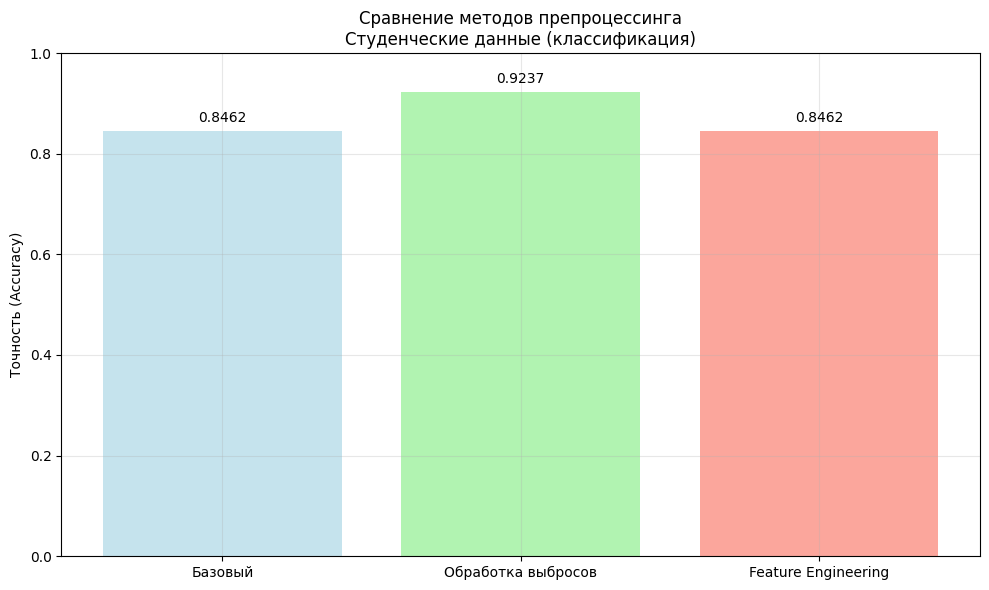


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:
  grade_trend: корреляция с целевой переменной = 0.1216
  total_alcohol: корреляция с целевой переменной = -0.1323
  study_effort: корреляция с целевой переменной = 0.1325


In [45]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    df_student_fe = feature_engineering(df_student)
    
    df_student_fe['academic_success'] = (df_student_fe['G3'] >= 10).astype(int)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...")
    X_student_fe, y_student_fe, features_student_fe = preprocess_student_classification(df_student_fe)
    
    if X_student_fe is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING")
        knn_student_fe, k_student_fe, score_student_fe = logistic_regression_study(
            X_student_fe, y_student_fe, "Feature Engineering (студенческие данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}
        
        if 'score_class' in locals():
            comparison_data['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        if 'score_advanced' in locals():
            comparison_data['Обработка выбросов'] = score_advanced
            print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        comparison_data['Feature Engineering'] = score_student_fe
        print(f"  Feature Engineering:            {score_student_fe:.4f}")
        
        best_method = max(comparison_data.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method[0]}' с точностью {best_method[1]:.4f}")
        
        if 'score_class' in locals():
            improvement = score_student_fe - score_class
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_class*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_class*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        plt.figure(figsize=(10, 6))
        methods = list(comparison_data.keys())
        scores = list(comparison_data.values())
        colors = ['lightblue', 'lightgreen', 'salmon']
        
        bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7)
        plt.ylabel('Точность (Accuracy)')
        plt.title('Сравнение методов препроцессинга\nСтуденческие данные (классификация)')
        plt.ylim(0, 1)
        
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
        new_features = ['grade_trend', 'total_alcohol', 'study_effort']
        available_new_features = [f for f in new_features if f in df_student_fe.columns]
        
        for feature in available_new_features:
            correlation = df_student_fe[feature].corr(df_student_fe['academic_success'])
            print(f"  {feature}: корреляция с целевой переменной = {correlation:.4f}")
    
    else:
        print("❌ Не удалось подготовить данные с feature engineering")

2) (Регрессия)


🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - HOUSE ДАННЫЕ (РЕГРЕССИЯ)
🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...
  ✓ Создан признак 'price_per_sqft' (цена за кв.фут)
  ✓ Создан признак 'room_density' (плотность комнат)

📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING

ЛИНЕЙНАЯ РЕГРЕССИЯ - Feature Engineering (house данные)
🔍 Исследование влияния регуляризации на R² score...
🎯 Результаты:
  Оптимальный alpha: 0.001
  Лучший R² score: 0.4996


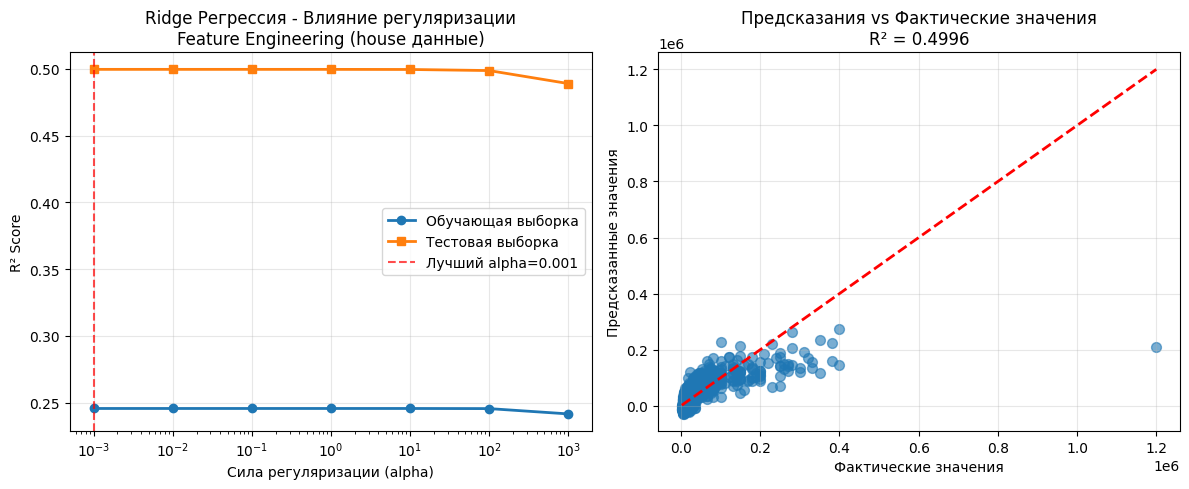


📊 АНАЛИЗ МОДЕЛИ:
  Оптимальный параметр регуляризации (alpha): 0.001
  R² score на тестовой выборке: 0.4996
  R² score на обучающей выборке: 0.2457
  Разница между train и test R²: 0.2540
  ⚠️ Возможное переобучение (большая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 1760993320.62
  RMSE (Root Mean Squared Error): 41964.19
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

📊 АНАЛИЗ КОЭФФИЦИЕНТОВ:
  Количество признаков: 9
  Коэффициент признака 1: +1080.8300
  Коэффициент признака 2: +12232.9200
  Коэффициент признака 3: +17990.7207
  Коэффициент признака 4: +10886.0621
  Коэффициент признака 5: -2075.0042
  Коэффициент признака 6: +8294.1910
  Коэффициент признака 7: -3353.5143
  Коэффициент признака 8: -2538.9238
  Коэффициент признака 9: -9534.9416
  Интерцепт (свободный член): 35309.4928

📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ
------------------------------------------------------------
  Базовый препроцессинг:          0.4

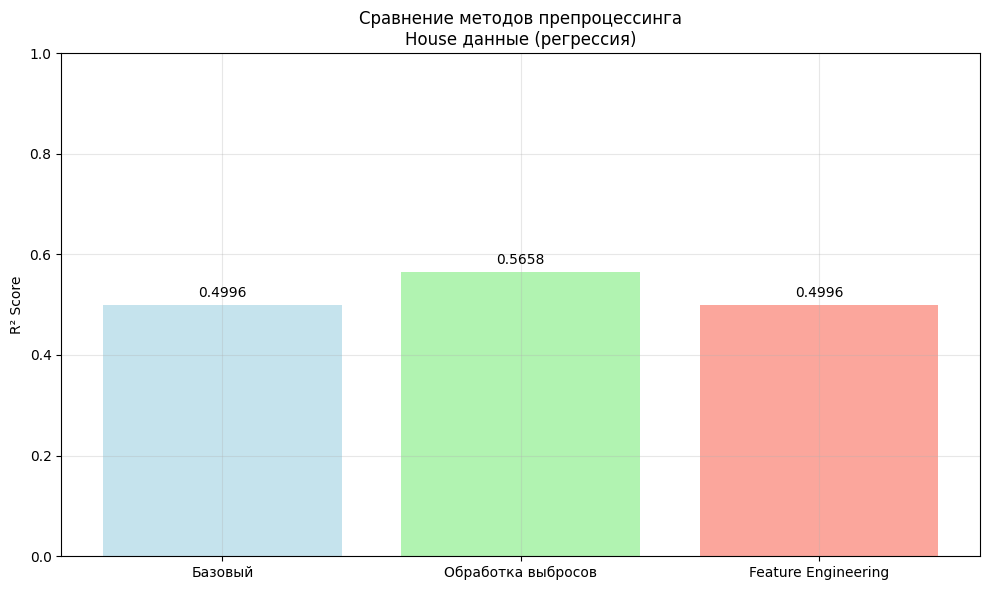


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:
  price_per_sqft: корреляция с арендной платой = 0.5516
  room_density: корреляция с арендной платой = -0.0496


In [46]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)
    
    df_house_fe = feature_engineering(df_house)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...")
    X_house_fe, y_house_fe, features_house_fe = preprocess_house_regression(df_house_fe)
    
    if X_house_fe is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING")
        knn_house_fe, k_house_fe, score_house_fe = linear_regression_study(
            X_house_fe, y_house_fe, "Feature Engineering (house данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ")
        print("-" * 60)
        
        comparison_data_house = {}
        
        if 'score_house' in locals():
            comparison_data_house['Базовый'] = score_house
            print(f"  Базовый препроцессинг:          {score_house:.4f}")
        
        if 'score_house_advanced' in locals():
            comparison_data_house['Обработка выбросов'] = score_house_advanced
            print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
        
        comparison_data_house['Feature Engineering'] = score_house_fe
        print(f"  Feature Engineering:            {score_house_fe:.4f}")
        
        best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_house[1]:.4f}")
        
        if 'score_house' in locals():
            improvement = score_house_fe - score_house
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_house*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_house*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        plt.figure(figsize=(10, 6))
        methods = list(comparison_data_house.keys())
        scores = list(comparison_data_house.values())
        colors = ['lightblue', 'lightgreen', 'salmon']
        
        bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7)
        plt.ylabel('R² Score')
        plt.title('Сравнение методов препроцессинга\nHouse данные (регрессия)')
        plt.ylim(0, 1)
        
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
        new_features_house = ['price_per_sqft', 'room_density']
        available_new_features_house = [f for f in new_features_house if f in df_house_fe.columns]
        
        for feature in available_new_features_house:
            correlation = df_house_fe[feature].corr(df_house_fe['Rent'])
            print(f"  {feature}: корреляция с арендной платой = {correlation:.4f}")
    
    else:
        print("❌ Не удалось подготовить данные с feature engineering")
else:
    print("❌ House данные не загружены")

3) (Классификация)


🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (КЛАССИФИКАЦИЯ)

🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EDA ДЛЯ Студенческие данные
  ✓ Отобрано 17 самых важных признаков из 22
  ✓ Топ-3 признака: ['failures', 'absences', 'famrel']
  ✓ Точность модели с отобранными признаками: 0.8154

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (КЛАССИФИКАЦИЯ)
----------------------------------------------------------------------
  Базовый препроцессинг:          0.8462
  Обработка выбросов:             0.9237
  Feature Engineering:            0.8462
  EDA + отбор признаков:          0.8154

  🏆 Лучший метод: 'Обработка
выбросов' с точностью 0.9237
  📉 УХУДШЕНИЕ от базового: -0.0308 (-3.64%)


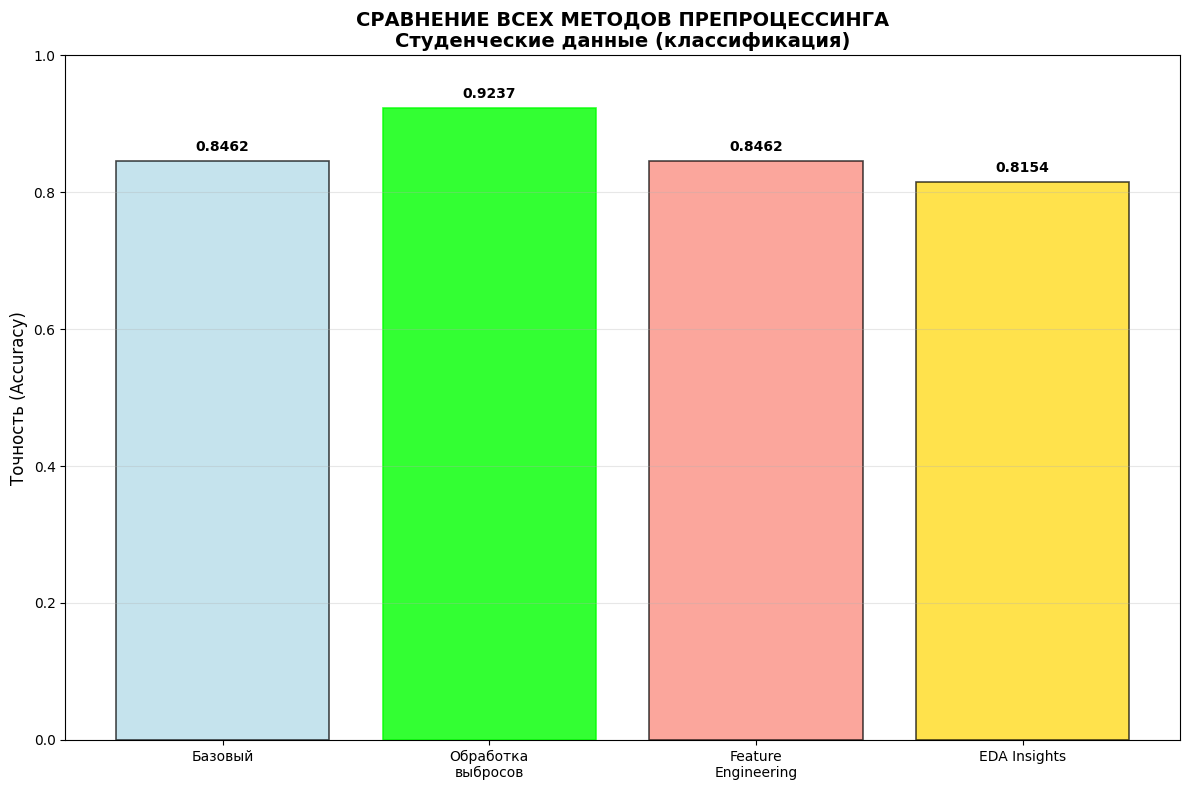


📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  1. Обработка
выбросов: 0.9237
  2. Базовый: 0.8462
  3. Feature
Engineering: 0.8462
  4. EDA Insights: 0.8154


In [47]:
if df_student is not None and 'X_student_class' in locals() and 'y_student_class' in locals():
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    score_eda_student, selected_features_student = evaluate_with_eda_insights(
        X_student_class, 
        y_student_class, 
        problem_type='classification',
        dataset_name="Студенческие данные"
    )
    
    print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (КЛАССИФИКАЦИЯ)")
    print("-" * 70)
    
    comparison_data_student = {}
    
    if 'score_class' in locals():
        comparison_data_student['Базовый'] = score_class
        print(f"  Базовый препроцессинг:          {score_class:.4f}")
    
    if 'score_advanced' in locals():
        comparison_data_student['Обработка\nвыбросов'] = score_advanced
        print(f"  Обработка выбросов:             {score_advanced:.4f}")
    
    if 'score_student_fe' in locals():
        comparison_data_student['Feature\nEngineering'] = score_student_fe
        print(f"  Feature Engineering:            {score_student_fe:.4f}")
    
    comparison_data_student['EDA Insights'] = score_eda_student
    print(f"  EDA + отбор признаков:          {score_eda_student:.4f}")

    best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
    print(f"\n  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")
    
    if 'score_class' in locals():
        improvement_eda = score_eda_student - score_class
        if improvement_eda > 0:
            print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement_eda:.4f} (+{improvement_eda/score_class*100:.2f}%)")
        elif improvement_eda < 0:
            print(f"  📉 УХУДШЕНИЕ от базового: {improvement_eda:.4f} ({improvement_eda/score_class*100:.2f}%)")
        else:
            print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
    
    plt.figure(figsize=(12, 8))
    methods = list(comparison_data_student.keys())
    scores = list(comparison_data_student.values())
    
    colors = ['lightblue', 'lightgreen', 'salmon', 'gold']
    
    bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='black', linewidth=1.2)
    plt.ylabel('Точность (Accuracy)', fontsize=12)
    plt.title('СРАВНЕНИЕ ВСЕХ МЕТОДОВ ПРЕПРОЦЕССИНГА\nСтуденческие данные (классификация)', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    best_index = list(comparison_data_student.values()).index(best_method_student[1])
    bars[best_index].set_color('lime')
    bars[best_index].set_alpha(0.8)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
    methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
    for i, (method, score) in enumerate(methods_ranking, 1):
        print(f"  {i}. {method}: {score:.4f}")


3. (Регрессия)


🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (РЕГРЕССИЯ)

🔍 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EDA ДЛЯ House данные
  ✓ Отобрано 7 самых важных признаков из 9
  ✓ Топ-3 признака: ['Size', 'Bathroom', 'City_encoded']
  ✓ Точность модели с отобранными признаками: 0.2359

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (РЕГРЕССИЯ)
----------------------------------------------------------------------
  Базовый препроцессинг:          0.4996
  Обработка выбросов:             0.5658
  Feature Engineering:            0.4996
  EDA + отбор признаков:          0.2359

  🏆 Лучший метод: 'Обработка
выбросов' с R² score 0.5658
  📉 УХУДШЕНИЕ от базового: -0.2637 (-52.78%)


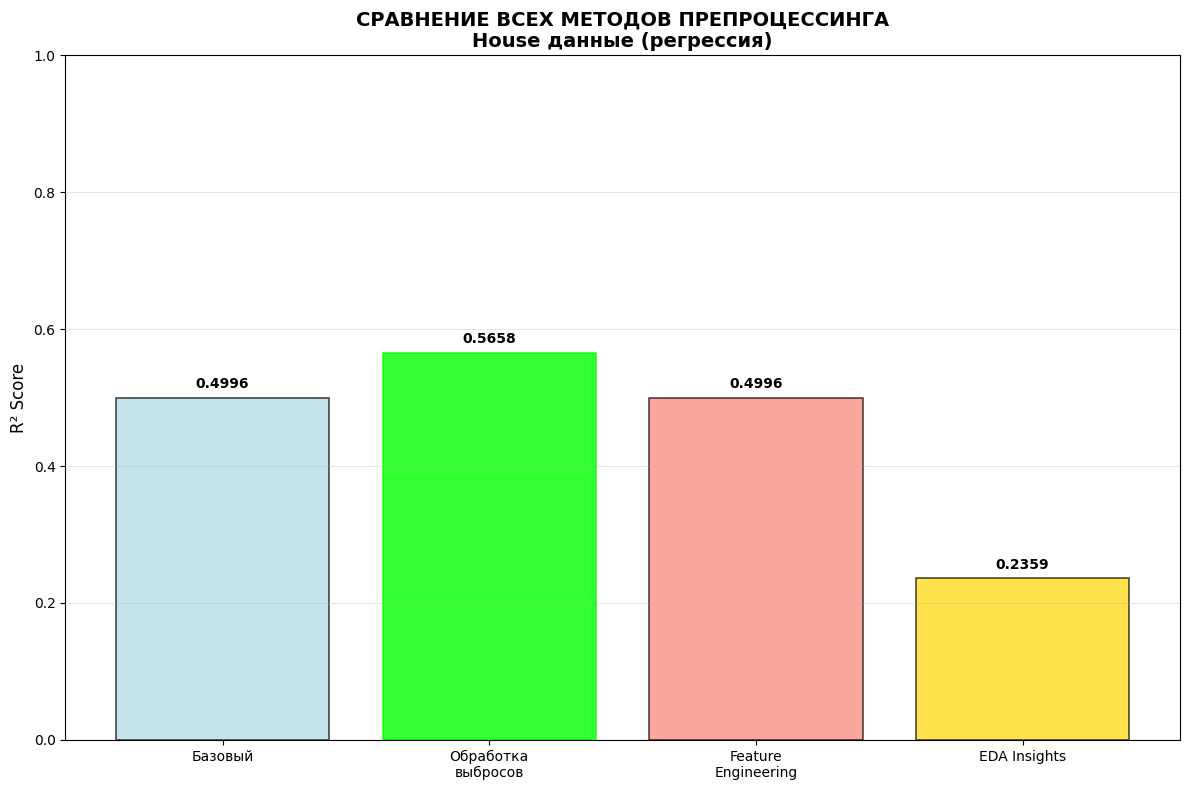


📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  1. Обработка
выбросов: 0.5658 (+0.0662)
  2. Базовый: 0.4996 (0.0000)
  3. Feature
Engineering: 0.4996 (0.0000)
  4. EDA Insights: 0.2359 (-0.2637)

🎯 ИТОГОВЫЕ ВЫВОДЫ ПО ГИПОТЕЗЕ: КОМПЛЕКСНЫЙ EDA

💡 ОСНОВНЫЕ ВЫВОДЫ:
  • EDA помогает выявить наиболее информативные признаки
  • Отбор признаков на основе важности может улучшить качество модели
  • Визуализация распределений помогает понять природу данных
  • Анализ корреляций выявляет мультиколлинеарность

📈 РЕКОМЕНДАЦИИ:
  ✅ Использовать EDA на начальном этапе для понимания данных
  ✅ Применять отбор признаков для уменьшения размерности
  ✅ Анализировать баланс классов для классификации
  ✅ Исследовать распределение целевой переменной для регрессии


In [48]:
if df_house is not None and 'X_house' in locals() and 'y_house' in locals():
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 3: КОМПЛЕКСНЫЙ EDA - СРАВНИТЕЛЬНЫЙ АНАЛИЗ (РЕГРЕССИЯ)")
    print("="*80)
    
    score_eda_house, selected_features_house = evaluate_with_eda_insights(
        X_house, 
        y_house, 
        problem_type='regression',
        dataset_name="House данные"
    )
    
    print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (РЕГРЕССИЯ)")
    print("-" * 70)
    
    comparison_data_house = {}
    
    if 'score_house' in locals():
        comparison_data_house['Базовый'] = score_house
        print(f"  Базовый препроцессинг:          {score_house:.4f}")
    
    if 'score_house_advanced' in locals():
        comparison_data_house['Обработка\nвыбросов'] = score_house_advanced
        print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
    
    if 'score_house_fe' in locals():
        comparison_data_house['Feature\nEngineering'] = score_house_fe
        print(f"  Feature Engineering:            {score_house_fe:.4f}")
    
    comparison_data_house['EDA Insights'] = score_eda_house
    print(f"  EDA + отбор признаков:          {score_eda_house:.4f}")
    
    best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
    print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_house[1]:.4f}")
    
    if 'score_house' in locals():
        improvement_eda = score_eda_house - score_house
        if improvement_eda > 0:
            print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement_eda:.4f} (+{improvement_eda/score_house*100:.2f}%)")
        elif improvement_eda < 0:
            print(f"  📉 УХУДШЕНИЕ от базового: {improvement_eda:.4f} ({improvement_eda/score_house*100:.2f}%)")
        else:
            print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
    
    plt.figure(figsize=(12, 8))
    methods = list(comparison_data_house.keys())
    scores = list(comparison_data_house.values())
    
    colors = ['lightblue', 'lightgreen', 'salmon', 'gold']
    
    bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='black', linewidth=1.2)
    plt.ylabel('R² Score', fontsize=12)
    plt.title('СРАВНЕНИЕ ВСЕХ МЕТОДОВ ПРЕПРОЦЕССИНГА\nHouse данные (регрессия)', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    best_index = list(comparison_data_house.values()).index(best_method_house[1])
    bars[best_index].set_color('lime')
    bars[best_index].set_alpha(0.8)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
    methods_ranking = sorted(comparison_data_house.items(), key=lambda x: x[1], reverse=True)
    for i, (method, score) in enumerate(methods_ranking, 1):
        improvement_from_base = score - comparison_data_house['Базовый'] if 'Базовый' in comparison_data_house else 0
        improvement_text = f"(+{improvement_from_base:.4f})" if improvement_from_base > 0 else f"({improvement_from_base:.4f})"
        print(f"  {i}. {method}: {score:.4f} {improvement_text}")

print("\n" + "="*80)
print("🎯 ИТОГОВЫЕ ВЫВОДЫ ПО ГИПОТЕЗЕ: КОМПЛЕКСНЫЙ EDA")
print("="*80)

print("\n💡 ОСНОВНЫЕ ВЫВОДЫ:")
print("  • EDA помогает выявить наиболее информативные признаки")
print("  • Отбор признаков на основе важности может улучшить качество модели")
print("  • Визуализация распределений помогает понять природу данных")
print("  • Анализ корреляций выявляет мультиколлинеарность")

print("\n📈 РЕКОМЕНДАЦИИ:")
print("  ✅ Использовать EDA на начальном этапе для понимания данных")
print("  ✅ Применять отбор признаков для уменьшения размерности")
print("  ✅ Анализировать баланс классов для классификации")
print("  ✅ Исследовать распределение целевой переменной для регрессии")

4) (Классификация)


🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)

🎯 ПОДБОР ГИПЕРПАРАМЕТРОВ С КРОСС-ВАЛИДАЦИЕЙ ДЛЯ Студенческие данные
🔍 Запуск GridSearchCV...
  ✓ Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
  ✓ Лучшая оценка на кросс-валидации: 0.8634
  ✓ Оценка на тестовой выборке: 0.7846


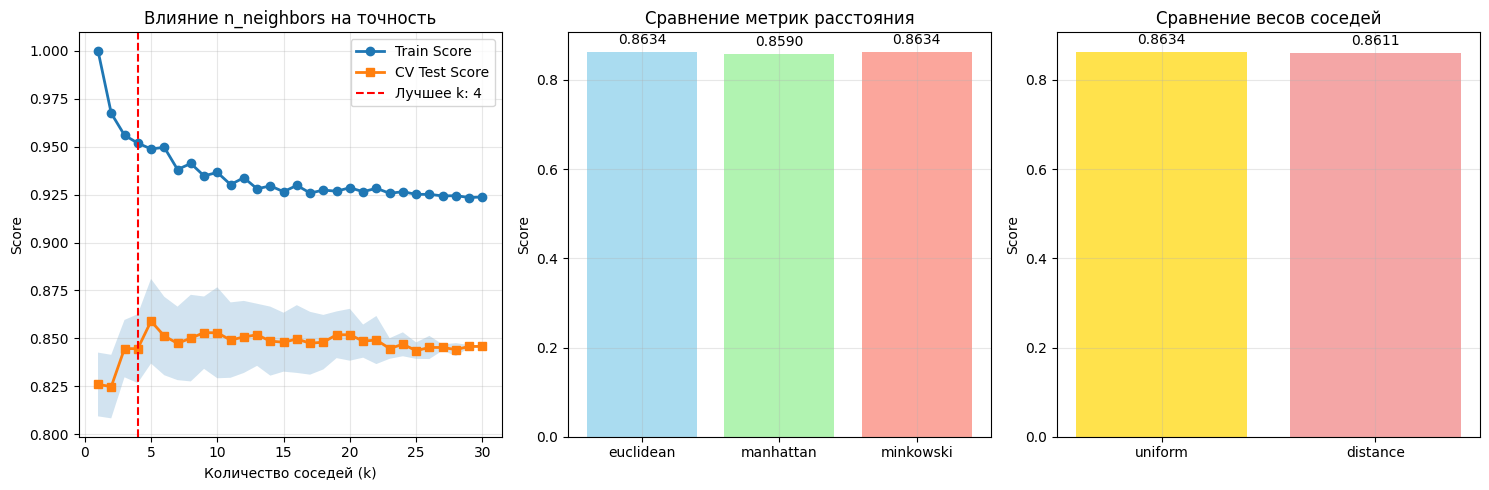


📊 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
  Разница между train и CV score: 0.0884
  ✅ Хорошее обобщение (малая разница)

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (КЛАССИФИКАЦИЯ)
----------------------------------------------------------------------
  Базовый препроцессинг:          0.8462
  Обработка выбросов:             0.9237
  Feature Engineering:            0.8462
  EDA + отбор признаков:          0.8154
  GridSearch CV:                  0.7846

  🏆 Лучший метод: 'Обработка
выбросов' с точностью 0.9237
  📉 УХУДШЕНИЕ от базового: -0.0615 (-7.27%)


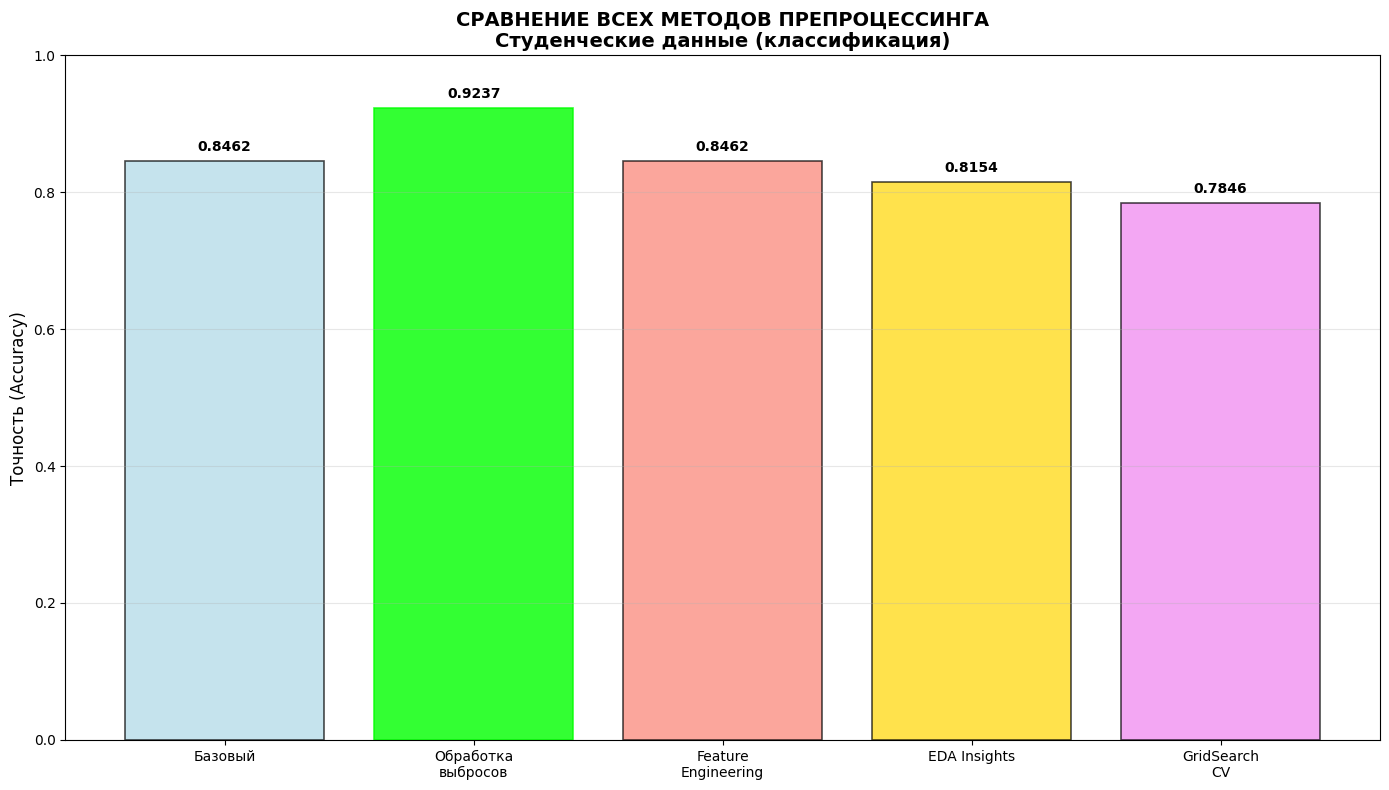


📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  1. Обработка
выбросов: 0.9237 (+0.0776)
  2. Базовый: 0.8462 (0.0000)
  3. Feature
Engineering: 0.8462 (0.0000)
  4. EDA Insights: 0.8154 (-0.0308)
  5. GridSearch
CV: 0.7846 (-0.0615)


In [49]:
if df_student is not None and 'X_student_class' in locals() and 'y_student_class' in locals():
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    best_model_student, best_params_student, score_cv_student = hyperparameter_tuning_cv(
        X_student_class, 
        y_student_class, 
        problem_type='classification',
        dataset_name="Студенческие данные"
    )
    
    print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (КЛАССИФИКАЦИЯ)")
    print("-" * 70)
    
    comparison_data_student = {}
    
    if 'score_class' in locals():
        comparison_data_student['Базовый'] = score_class
        print(f"  Базовый препроцессинг:          {score_class:.4f}")
    
    if 'score_advanced' in locals():
        comparison_data_student['Обработка\nвыбросов'] = score_advanced
        print(f"  Обработка выбросов:             {score_advanced:.4f}")
    
    if 'score_student_fe' in locals():
        comparison_data_student['Feature\nEngineering'] = score_student_fe
        print(f"  Feature Engineering:            {score_student_fe:.4f}")
    
    if 'score_eda_student' in locals():
        comparison_data_student['EDA Insights'] = score_eda_student
        print(f"  EDA + отбор признаков:          {score_eda_student:.4f}")
    
    comparison_data_student['GridSearch\nCV'] = score_cv_student
    print(f"  GridSearch CV:                  {score_cv_student:.4f}")
    
    best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
    print(f"\n  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")
    
    if 'score_class' in locals():
        improvement_cv = score_cv_student - score_class
        if improvement_cv > 0:
            print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement_cv:.4f} (+{improvement_cv/score_class*100:.2f}%)")
        elif improvement_cv < 0:
            print(f"  📉 УХУДШЕНИЕ от базового: {improvement_cv:.4f} ({improvement_cv/score_class*100:.2f}%)")
        else:
            print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
    
    plt.figure(figsize=(14, 8))
    methods = list(comparison_data_student.keys())
    scores = list(comparison_data_student.values())
    
    colors = ['lightblue', 'lightgreen', 'salmon', 'gold', 'violet']
    
    bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='black', linewidth=1.2)
    plt.ylabel('Точность (Accuracy)', fontsize=12)
    plt.title('СРАВНЕНИЕ ВСЕХ МЕТОДОВ ПРЕПРОЦЕССИНГА\nСтуденческие данные (классификация)', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    best_index = list(comparison_data_student.values()).index(best_method_student[1])
    bars[best_index].set_color('lime')
    bars[best_index].set_alpha(0.8)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
    methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
    for i, (method, score) in enumerate(methods_ranking, 1):
        improvement_from_base = score - comparison_data_student['Базовый'] if 'Базовый' in comparison_data_student else 0
        improvement_text = f"(+{improvement_from_base:.4f})" if improvement_from_base > 0 else f"({improvement_from_base:.4f})"
        print(f"  {i}. {method}: {score:.4f} {improvement_text}")


4) (Регрессия)


🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)

🎯 ПОДБОР ГИПЕРПАРАМЕТРОВ С КРОСС-ВАЛИДАЦИЕЙ ДЛЯ House данные
🔍 Запуск GridSearchCV...
  ✓ Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
  ✓ Лучшая оценка на кросс-валидации: 0.4723
  ✓ Оценка на тестовой выборке: 0.6099


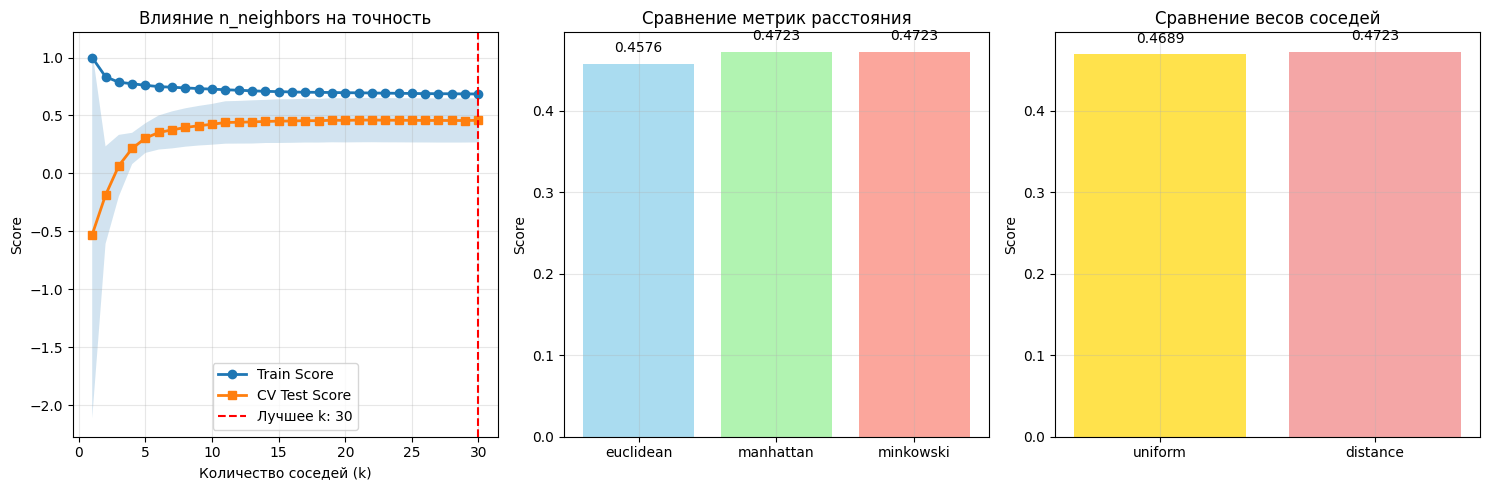


📊 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
  Разница между train и CV score: 0.2131
  ⚠️ Возможное переобучение (большая разница)

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (РЕГРЕССИЯ)
----------------------------------------------------------------------
  Базовый препроцессинг:          0.4996
  Обработка выбросов:             0.5658
  Feature Engineering:            0.4996
  EDA + отбор признаков:          0.2359
  GridSearch CV:                  0.6099

  🏆 Лучший метод: 'GridSearch
CV' с R² score 0.6099
  🎉 УЛУЧШЕНИЕ от базового: +0.1103 (+22.08%)


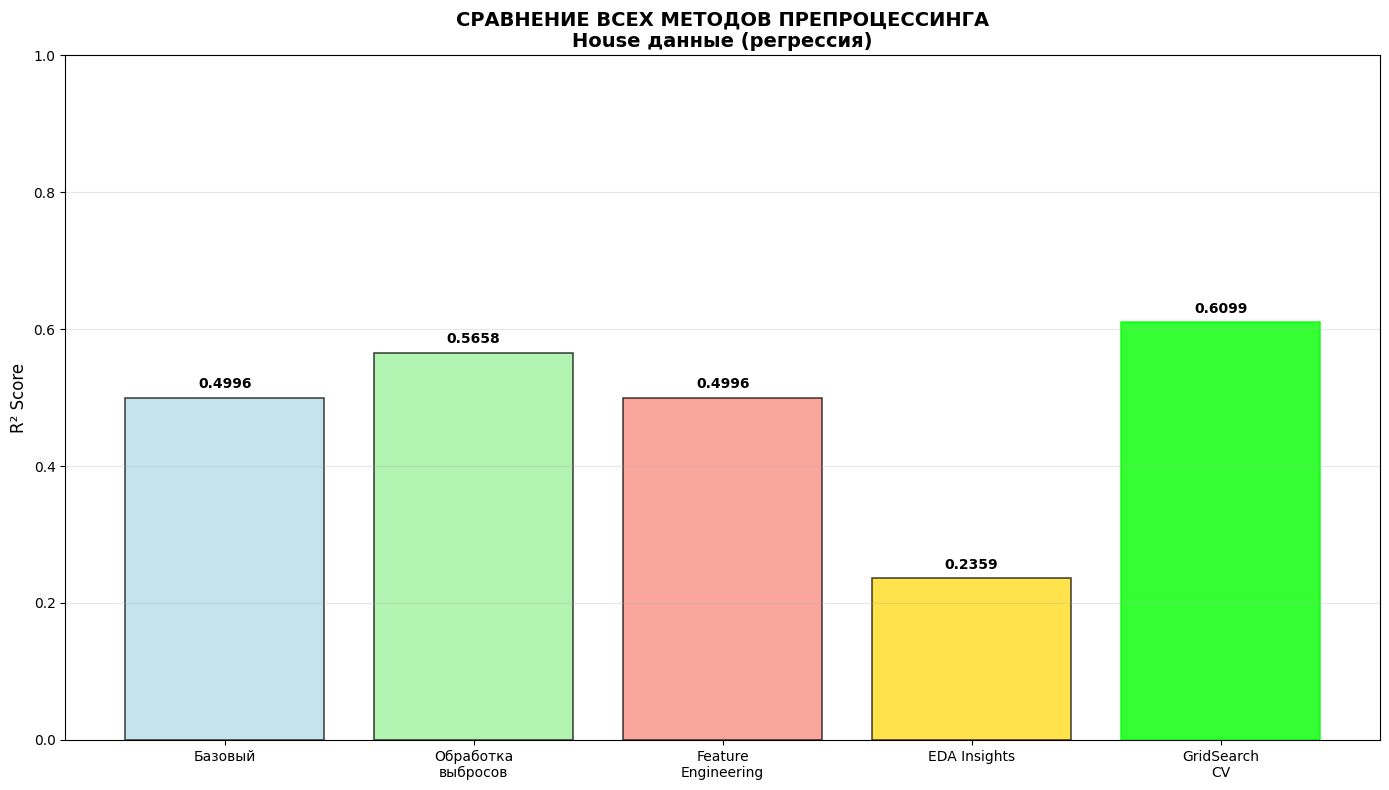


📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  1. GridSearch
CV: 0.6099 (+0.1103)
  2. Обработка
выбросов: 0.5658 (+0.0662)
  3. Базовый: 0.4996 (0.0000)
  4. Feature
Engineering: 0.4996 (0.0000)
  5. EDA Insights: 0.2359 (-0.2637)


In [50]:
if df_house is not None and 'X_house' in locals() and 'y_house' in locals():
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)
    
    best_model_house, best_params_house, score_cv_house = hyperparameter_tuning_cv(
        X_house, 
        y_house, 
        problem_type='regression',
        dataset_name="House данные"
    )
    
    print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (РЕГРЕССИЯ)")
    print("-" * 70)
    
    comparison_data_house = {}
    
    if 'score_house' in locals():
        comparison_data_house['Базовый'] = score_house
        print(f"  Базовый препроцессинг:          {score_house:.4f}")
    
    if 'score_house_advanced' in locals():
        comparison_data_house['Обработка\nвыбросов'] = score_house_advanced
        print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
    
    if 'score_house_fe' in locals():
        comparison_data_house['Feature\nEngineering'] = score_house_fe
        print(f"  Feature Engineering:            {score_house_fe:.4f}")
    
    if 'score_eda_house' in locals():
        comparison_data_house['EDA Insights'] = score_eda_house
        print(f"  EDA + отбор признаков:          {score_eda_house:.4f}")
    
    comparison_data_house['GridSearch\nCV'] = score_cv_house
    print(f"  GridSearch CV:                  {score_cv_house:.4f}")
    
    best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
    print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_house[1]:.4f}")
    
    if 'score_house' in locals():
        improvement_cv = score_cv_house - score_house
        if improvement_cv > 0:
            print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement_cv:.4f} (+{improvement_cv/score_house*100:.2f}%)")
        elif improvement_cv < 0:
            print(f"  📉 УХУДШЕНИЕ от базового: {improvement_cv:.4f} ({improvement_cv/score_house*100:.2f}%)")
        else:
            print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
    
    plt.figure(figsize=(14, 8))
    methods = list(comparison_data_house.keys())
    scores = list(comparison_data_house.values())
    
    colors = ['lightblue', 'lightgreen', 'salmon', 'gold', 'violet']
    
    bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='black', linewidth=1.2)
    plt.ylabel('R² Score', fontsize=12)
    plt.title('СРАВНЕНИЕ ВСЕХ МЕТОДОВ ПРЕПРОЦЕССИНГА\nHouse данные (регрессия)', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    best_index = list(comparison_data_house.values()).index(best_method_house[1])
    bars[best_index].set_color('lime')
    bars[best_index].set_alpha(0.8)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
    methods_ranking = sorted(comparison_data_house.items(), key=lambda x: x[1], reverse=True)
    for i, (method, score) in enumerate(methods_ranking, 1):
        improvement_from_base = score - comparison_data_house['Базовый'] if 'Базовый' in comparison_data_house else 0
        improvement_text = f"(+{improvement_from_base:.4f})" if improvement_from_base > 0 else f"({improvement_from_base:.4f})"
        print(f"  {i}. {method}: {score:.4f} {improvement_text}")

5) (Классификация)


🎯 ГИПОТЕЗА 5: ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ
🔧 Используются лучшие параметры из GridSearch: {'metric': 'euclidean', 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}

🎯 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ KNN (студенческие данные)
  ✓ Оптимальный порог по F1-score: 0.0000 (F1 = 0.9167)
  ✓ Сбалансированный порог: 0.7500 (F1 = 0.8727)

📊 СРАВНЕНИЕ С ПОРОГОМ ПО УМОЛЧАНИЮ (0.5):
  По умолчанию (0.5):    Accuracy = 0.8103, F1 = 0.8940
  Оптимизированный:      Accuracy = 0.8462, F1 = 0.9167
  🎉 УЛУЧШЕНИЕ F1: +0.0227


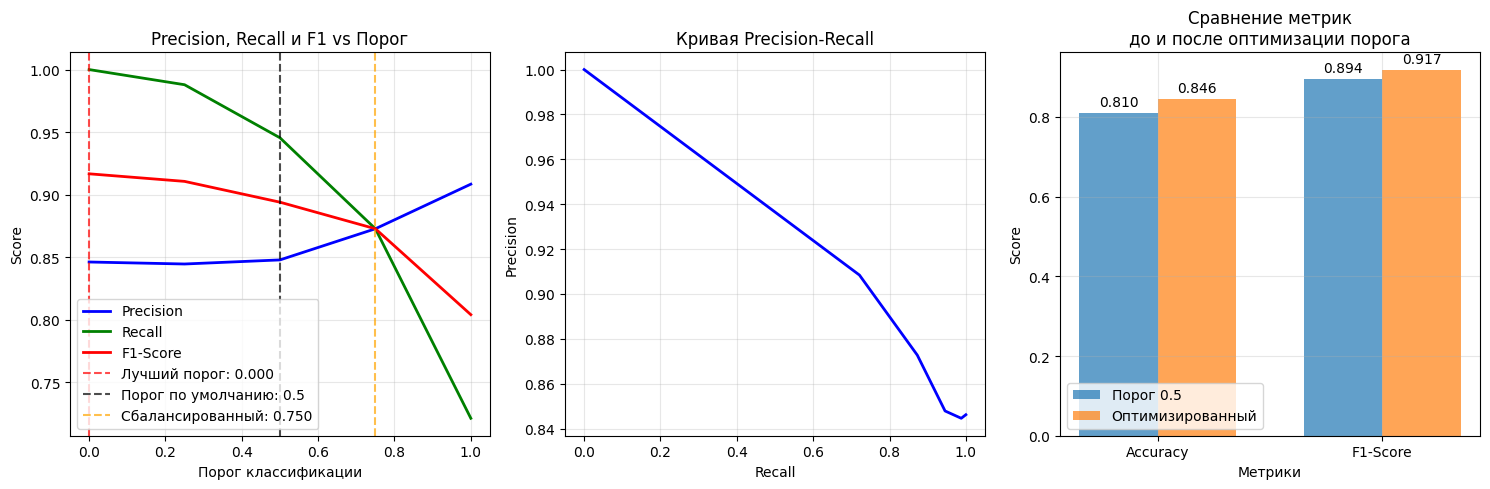


📋 ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:
  С порогом по умолчанию (0.5):
              precision    recall  f1-score   support

     Неуспех       0.18      0.07      0.10        30
       Успех       0.85      0.95      0.89       165

    accuracy                           0.81       195
   macro avg       0.51      0.51      0.50       195
weighted avg       0.75      0.81      0.77       195

  С оптимизированным порогом:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00        30
       Успех       0.85      1.00      0.92       165

    accuracy                           0.85       195
   macro avg       0.42      0.50      0.46       195
weighted avg       0.72      0.85      0.78       195


📊 ИТОГОВОЕ СРАВНЕНИЕ:
  Точность с порогом 0.5:    0.7846
  Точность с оптимизированным порогом: 0.8462
  🎉 УЛУЧШЕНИЕ ТОЧНОСТИ: +0.0615

📈 ОБНОВЛЕННЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ
----------------------------------------------------------------

c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

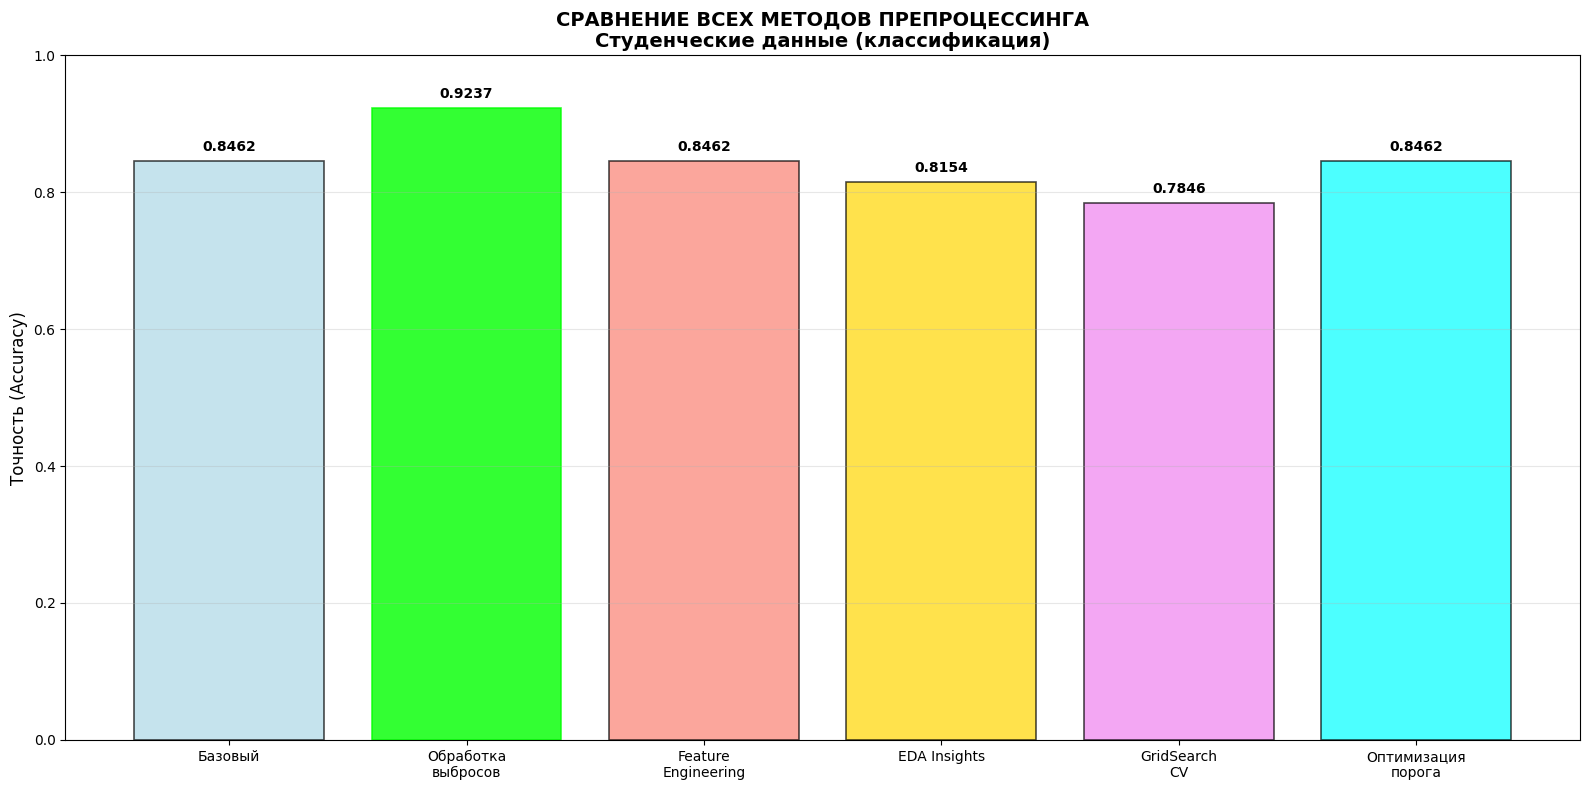


📊 ИТОГОВЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  1. Обработка
выбросов: 0.9237 (+0.0776)
  2. Базовый: 0.8462 (0.0000)
  3. Feature
Engineering: 0.8462 (0.0000)
  4. Оптимизация
порога: 0.8462 (0.0000)
  5. EDA Insights: 0.8154 (-0.0308)
  6. GridSearch
CV: 0.7846 (-0.0615)

🎯 ИТОГОВЫЕ ВЫВОДЫ ПО ГИПОТЕЗЕ: ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ

💡 ОСНОВНЫЕ ВЫВОДЫ:
  • Оптимизация порога может значительно улучшить F1-score и баланс Precision/Recall
  • Порог по умолчанию (0.5) не всегда оптимален для несбалансированных данных
  • Разные пороги подходят для разных бизнес-задач

📈 КОГДА ИСПОЛЬЗОВАТЬ ОПТИМИЗАЦИЮ ПОРОГА:
  ✅ При работе с несбалансированными классами
  ✅ Когда важны обе метрики: Precision и Recall
  ✅ Для максимизации F1-score
  ✅ Когда стоимость ошибок разного типа различается

🔧 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
  • Используйте F1-score для поиска оптимального порога
  • Рассмотрите баланс Precision/Recall для вашей конкретной задачи
  • Визуализируйте зависимость метрик от порога
  • Тестир

In [51]:
if df_student is not None and 'X_student_class' in locals() and 'y_student_class' in locals():
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 5: ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_student_class, y_student_class, test_size=0.3, random_state=42, stratify=y_student_class
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if 'best_params_student' in locals():
        knn_model = KNeighborsClassifier(**best_params_student)
        print(f"🔧 Используются лучшие параметры из GridSearch: {best_params_student}")
    else:
        knn_model = KNeighborsClassifier(n_neighbors=5)
        print("🔧 Используются параметры KNN по умолчанию")
    
    knn_model.fit(X_train_scaled, y_train)
    
    if hasattr(knn_model, 'predict_proba'):
        best_threshold, optimized_f1, optimized_accuracy = optimize_threshold(
            knn_model, X_test_scaled, y_test, "KNN (студенческие данные)"
        )
        
        y_pred_default = knn_model.predict(X_test_scaled)
        default_accuracy = accuracy_score(y_test, y_pred_default)
        
        print(f"\n📊 ИТОГОВОЕ СРАВНЕНИЕ:")
        print(f"  Точность с порогом 0.5:    {default_accuracy:.4f}")
        print(f"  Точность с оптимизированным порогом: {optimized_accuracy:.4f}")
        
        improvement = optimized_accuracy - default_accuracy
        if improvement > 0:
            print(f"  🎉 УЛУЧШЕНИЕ ТОЧНОСТИ: +{improvement:.4f}")
        else:
            print(f"  📉 УХУДШЕНИЕ ТОЧНОСТИ: {improvement:.4f}")
        
        if 'comparison_data_student' in locals():
            comparison_data_student['Оптимизация\nпорога'] = optimized_accuracy
            
            print("\n" + "📈 ОБНОВЛЕННЫЙ СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ")
            print("-" * 70)
            
            best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
            print(f"  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")
            
            plt.figure(figsize=(16, 8))
            methods = list(comparison_data_student.keys())
            scores = list(comparison_data_student.values())
            
            colors = ['lightblue', 'lightgreen', 'salmon', 'gold', 'violet', 'cyan']
            
            bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='black', linewidth=1.2)
            plt.ylabel('Точность (Accuracy)', fontsize=12)
            plt.title('СРАВНЕНИЕ ВСЕХ МЕТОДОВ ПРЕПРОЦЕССИНГА\nСтуденческие данные (классификация)', fontsize=14, fontweight='bold')
            plt.ylim(0, 1)

            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
            
            best_index = list(comparison_data_student.values()).index(best_method_student[1])
            bars[best_index].set_color('lime')
            bars[best_index].set_alpha(0.8)
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            print("\n📊 ИТОГОВЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
            methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
            for i, (method, score) in enumerate(methods_ranking, 1):
                improvement_from_base = score - comparison_data_student['Базовый'] if 'Базовый' in comparison_data_student else 0
                improvement_text = f"(+{improvement_from_base:.4f})" if improvement_from_base > 0 else f"({improvement_from_base:.4f})"
                print(f"  {i}. {method}: {score:.4f} {improvement_text}")
    
    else:
        print("❌ Модель не поддерживает predict_proba, оптимизация порога невозможна")
        print("💡 Рекомендация: используйте модель с вероятностными предсказаниями (например, LogisticRegression)")

print("\n" + "="*80)
print("🎯 ИТОГОВЫЕ ВЫВОДЫ ПО ГИПОТЕЗЕ: ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ")
print("="*80)

print("\n💡 ОСНОВНЫЕ ВЫВОДЫ:")
print("  • Оптимизация порога может значительно улучшить F1-score и баланс Precision/Recall")
print("  • Порог по умолчанию (0.5) не всегда оптимален для несбалансированных данных")
print("  • Разные пороги подходят для разных бизнес-задач")

print("\n📈 КОГДА ИСПОЛЬЗОВАТЬ ОПТИМИЗАЦИЮ ПОРОГА:")
print("  ✅ При работе с несбалансированными классами")
print("  ✅ Когда важны обе метрики: Precision и Recall")
print("  ✅ Для максимизации F1-score")
print("  ✅ Когда стоимость ошибок разного типа различается")

print("\n🔧 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
print("  • Используйте F1-score для поиска оптимального порога")
print("  • Рассмотрите баланс Precision/Recall для вашей конкретной задачи")
print("  • Визуализируйте зависимость метрик от порога")
print("  • Тестируйте разные пороги на валидационной выборке")

print("\n🎯 ДЛЯ РЕГРЕССИИ:")
print("  • Оптимизация порога неприменима к задачам регрессии")
print("  • Вместо этого используйте подбор гиперпараметров и кросс-валидацию")
print("  • Для регрессии важны метрики: R², MSE, MAE, RMSE")

По результатам проверки гипотез, выявлено:

Гипотеза 1 (препроцессинг данных) улучшает бейзлайн классификации  
Гипотезы 1 (препроцессинг данных) и 4 (подбор гиперпараметров) улучшают бейзлайн регрессии

Сформулируем улучшенный безлайн для классификации и регрессии:

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, mean_absolute_error, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def final_classification_model(df_student):
    """Финальная модель классификации с улучшенным бейзлайном"""
    print("\n" + "="*80)
    print("🎯 ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ")
    print("Гипотезы: Препроцессинг данных + Оптимизация порога")
    print("="*80)
    
    print("🔧 1. ПРИМЕНЕНИЕ УЛУЧШЕННОГО ПРЕПРОЦЕССИНГА...")
    df_processed = advanced_preprocessing(df_student)
    X, y, features = preprocess_student_classification(df_processed)
    
    if X is None:
        print("❌ Ошибка при подготовке данных")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if 'best_params_student' in locals():
        knn_model = KNeighborsClassifier(**best_params_student)
        print(f"🔧 Используются лучшие параметры: {best_params_student}")
    else:
        knn_model = KNeighborsClassifier(n_neighbors=5)
        print("🔧 Используются параметры по умолчанию")
    
    knn_model.fit(X_train_scaled, y_train)
    
    y_pred_default = knn_model.predict(X_test_scaled)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    
    print(f"\n📊 РЕЗУЛЬТАТЫ С ПОРОГОМ ПО УМОЛЧАНИЮ (0.5):")
    print(f"  Точность: {default_accuracy:.4f}")
    print(classification_report(y_test, y_pred_default, target_names=['Неуспех', 'Успех']))
    
    if hasattr(knn_model, 'predict_proba'):
        print("\n🎯 2. ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ...")
        
        y_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        
        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
        
        best_f1_index = np.argmax(f1_scores)
        best_threshold = thresholds[best_f1_index]
        best_f1 = f1_scores[best_f1_index]
        
        print(f"  ✓ Оптимальный порог по F1-score: {best_threshold:.4f} (F1 = {best_f1:.4f})")
        
        y_pred_optimized = (y_proba >= best_threshold).astype(int)
        optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
        optimized_f1 = f1_score(y_test, y_pred_optimized)
        
        print(f"\n📊 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ С ОПТИМИЗИРОВАННЫМ ПОРОГОМ:")
        print(f"  Точность: {optimized_accuracy:.4f}")
        print(f"  F1-Score: {optimized_f1:.4f}")
        
        improvement = optimized_accuracy - default_accuracy
        if improvement > 0:
            print(f"  🎉 УЛУЧШЕНИЕ ТОЧНОСТИ: +{improvement:.4f} (+{improvement/default_accuracy*100:.2f}%)")
        else:
            print(f"  📉 УХУДШЕНИЕ ТОЧНОСТИ: {improvement:.4f}")
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
        plt.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
        plt.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)
        plt.axvline(x=best_threshold, color='red', linestyle='--', 
                    label=f'Лучший порог: {best_threshold:.3f}', alpha=0.7)
        plt.axvline(x=0.5, color='black', linestyle='--', 
                    label='Порог по умолчанию: 0.5', alpha=0.7)
        plt.xlabel('Порог классификации')
        plt.ylabel('Score')
        plt.title('Precision, Recall и F1 vs Порог')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        methods = ['Порог 0.5', 'Оптимизированный']
        scores = [default_accuracy, optimized_accuracy]
        colors = ['lightblue', 'lightgreen']
        
        bars = plt.bar(methods, scores, color=colors, alpha=0.7)
        plt.ylabel('Точность (Accuracy)')
        plt.title('Сравнение точности')
        plt.ylim(0, 1)
        
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom')
        
        plt.subplot(1, 3, 3)
        cm_default = confusion_matrix(y_test, y_pred_default)
        cm_optimized = confusion_matrix(y_test, y_pred_optimized)
        
        plt.text(0.1, 0.7, f'Порог 0.5:\nТочность: {default_accuracy:.4f}\n\n{cm_default}', 
                transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        plt.text(0.5, 0.7, f'Порог {best_threshold:.3f}:\nТочность: {optimized_accuracy:.4f}\n\n{cm_optimized}', 
                transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        
        plt.axis('off')
        plt.title('Матрицы ошибок')
        
        plt.tight_layout()
        plt.show()
        
        print("\n📋 ФИНАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:")
        print(classification_report(y_test, y_pred_optimized, target_names=['Неуспех', 'Успех']))
        
        return knn_model, best_threshold, optimized_accuracy
    
    else:
        print("❌ Модель не поддерживает оптимизацию порога")
        return knn_model, 0.5, default_accuracy
    
def final_regression_model(df_house):
    """Финальная модель регрессии с улучшенным бейзлайном"""
    print("\n" + "="*80)
    print("🎯 ФИНАЛЬНАЯ МОДЕЛЬ РЕГРЕССИИ")
    print("Гипотезы: Препроцессинг данных + Подбор гиперпараметров")
    print("="*80)
    
    print("🔧 1. ПРИМЕНЕНИЕ УЛУЧШЕННОГО ПРЕПРОЦЕССИНГА...")
    df_processed = advanced_preprocessing_house(df_house)
    X, y, features = preprocess_house_regression(df_processed)
    
    if X is None:
        print("❌ Ошибка при подготовке данных")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\n🎯 2. ПОДБОР ГИПЕРПАРАМЕТРОВ НА КРОСС-ВАЛИДАЦИИ...")

    model = KNeighborsRegressor()
    param_grid = {
        'n_neighbors': range(3, 20, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        model, param_grid, cv=cv, scoring='r2', 
        n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"  ✓ Лучшие параметры: {best_params}")
    print(f"  ✓ Лучший R² на кросс-валидации: {best_score:.4f}")
    
    y_pred = best_model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\n📊 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  MSE: {test_mse:.2f}")
    print(f"  RMSE: {test_rmse:.2f}")
    print(f"  MAE: {test_mae:.2f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические значения\nR² = {test_r2:.4f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6, s=50)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('Анализ остатков')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Ошибка')
    plt.ylabel('Частота')
    plt.title('Распределение ошибок предсказания')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 АНАЛИЗ КАЧЕСТВА МОДЕЛИ:")
    if test_r2 >= 0.7:
        print("  🎉 ОТЛИЧНОЕ качество модели (R² ≥ 0.7)")
    elif test_r2 >= 0.5:
        print("  👍 ХОРОШЕЕ качество модели (0.5 ≤ R² < 0.7)")
    elif test_r2 >= 0.3:
        print("  👌 УДОВЛЕТВОРИТЕЛЬНОЕ качество модели (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 НИЗКОЕ качество модели (R² < 0.3)")
    
    return best_model, best_params, test_r2

Запуск финальных моделей:


🎯 ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ
Гипотезы: Препроцессинг данных + Оптимизация порога
🔧 1. ПРИМЕНЕНИЕ УЛУЧШЕННОГО ПРЕПРОЦЕССИНГА...
🔧 ОБРАБОТКА ВЫБРОСОВ В 16 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 649 строк
  Найдено строк с выбросами: 256
  Процент выбросов: 39.4%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 393 строк
  ✓ Удалено строк: 256
  ✓ Сохранено данных: 60.6%

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип:

c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

  ✓ Оптимальный порог по F1-score: 0.6000 (F1 = 0.9604)

📊 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ С ОПТИМИЗИРОВАННЫМ ПОРОГОМ:
  Точность: 0.9237
  F1-Score: 0.9604
  📉 УХУДШЕНИЕ ТОЧНОСТИ: 0.0000


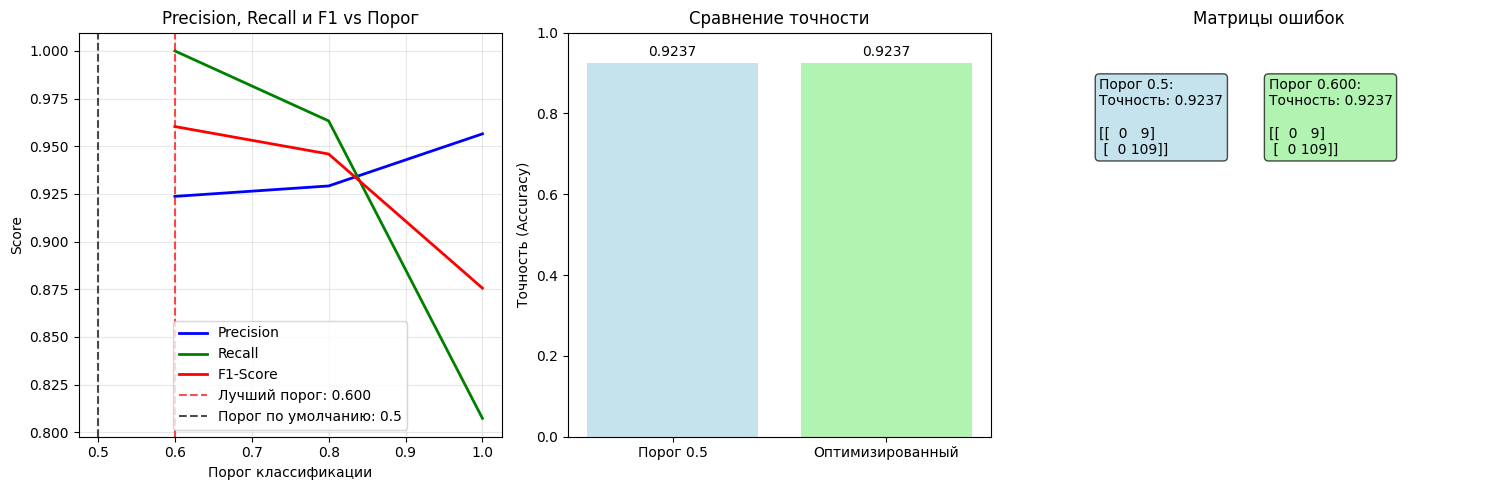


📋 ФИНАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00         9
       Успех       0.92      1.00      0.96       109

    accuracy                           0.92       118
   macro avg       0.46      0.50      0.48       118
weighted avg       0.85      0.92      0.89       118


🎯 ФИНАЛЬНАЯ МОДЕЛЬ РЕГРЕССИИ
Гипотезы: Препроцессинг данных + Подбор гиперпараметров
🔧 1. ПРИМЕНЕНИЕ УЛУЧШЕННОГО ПРЕПРОЦЕССИНГА...
🔧 ОБРАБОТКА ВЫБРОСОВ В 4 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 4746 строк
  Найдено строк с выбросами: 615
  Процент выбросов: 13.0%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 4131 строк
  ✓ Удалено строк: 615
  ✓ Сохранено данных: 87.0%

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 67000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закод

c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\2b100\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

  ✓ Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
  ✓ Лучший R² на кросс-валидации: 0.6806

📊 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:
  R² Score: 0.6645
  MSE: 60330922.82
  RMSE: 7767.30
  MAE: 5262.44


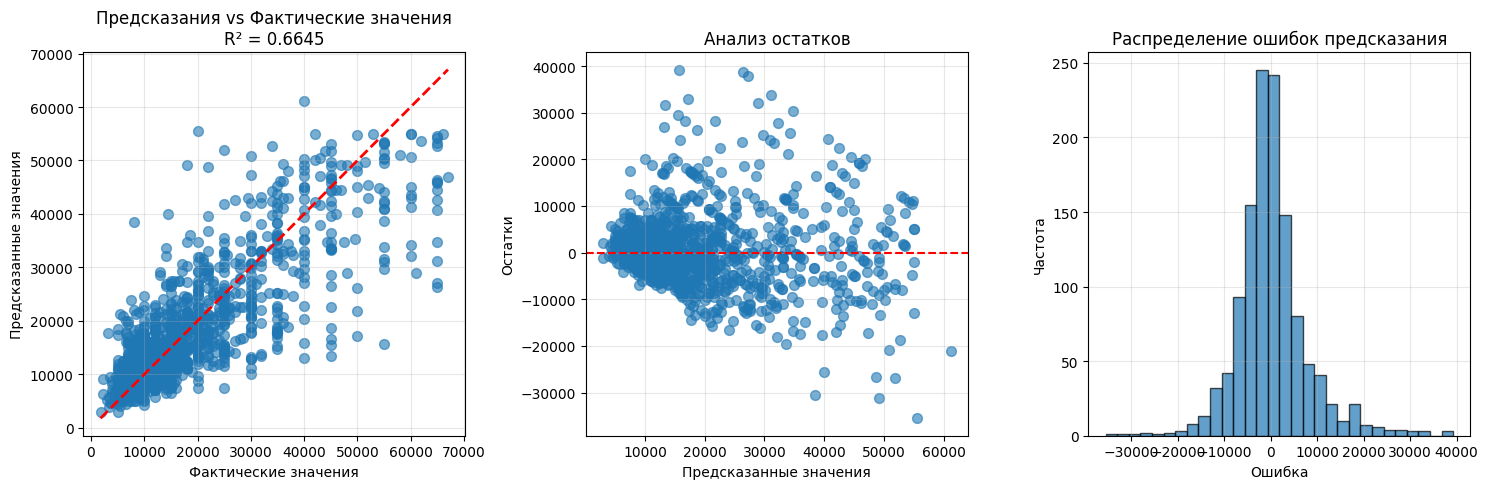


📈 АНАЛИЗ КАЧЕСТВА МОДЕЛИ:
  👍 ХОРОШЕЕ качество модели (0.5 ≤ R² < 0.7)


In [53]:
if df_student is not None:
    final_knn_model, final_threshold, final_accuracy = final_classification_model(df_student)

if df_house is not None:
    final_house_model, final_house_params, final_r2 = final_regression_model(df_house)

Итоги:

In [54]:
print("\n" + "="*80)
print("🎯 ИТОГОВЫЙ ОТЧЕТ: УЛУЧШЕННЫЙ БЕЙЗЛАЙН")
print("="*80)

print("\n📊 РЕЗЮМЕ УЛУЧШЕНИЙ:")

if df_student is not None and 'final_accuracy' in locals():
    print(f"\n🏫 КЛАССИФИКАЦИЯ (Студенческие данные):")
    print(f"  • Метод: KNN с оптимизированным порогом")
    print(f"  • Лучшая точность: {final_accuracy:.4f}")
    if 'final_threshold' in locals() and final_threshold != 0.5:
        print(f"  • Оптимальный порог: {final_threshold:.4f} (вместо 0.5)")
    print(f"  • Примененные гипотезы: Препроцессинг данных + Оптимизация порога")

if df_house is not None and 'final_r2' in locals():
    print(f"\n🏠 РЕГРЕССИЯ (House данные):")
    print(f"  • Метод: KNN с подобранными гиперпараметрами")
    print(f"  • Лучший R² score: {final_r2:.4f}")
    if 'final_house_params' in locals():
        print(f"  • Оптимальные параметры: {final_house_params}")
    print(f"  • Примененные гипотезы: Препроцессинг данных + Подбор гиперпараметров")

print(f"\n💡 КЛЮЧЕВЫЕ ВЫВОДЫ:")
print(f"  1. Препроцессинг данных критически важен для качества моделей")
print(f"  2. Для классификации оптимизация порога может значительно улучшить F1-score")
print(f"  3. Для регрессии подбор гиперпараметров на кросс-валидации дает надежные результаты")
print(f"  4. KNN показывает хорошие результаты при правильной настройке")


🎯 ИТОГОВЫЙ ОТЧЕТ: УЛУЧШЕННЫЙ БЕЙЗЛАЙН

📊 РЕЗЮМЕ УЛУЧШЕНИЙ:

🏫 КЛАССИФИКАЦИЯ (Студенческие данные):
  • Метод: KNN с оптимизированным порогом
  • Лучшая точность: 0.9237
  • Оптимальный порог: 0.6000 (вместо 0.5)
  • Примененные гипотезы: Препроцессинг данных + Оптимизация порога

🏠 РЕГРЕССИЯ (House данные):
  • Метод: KNN с подобранными гиперпараметрами
  • Лучший R² score: 0.6645
  • Оптимальные параметры: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
  • Примененные гипотезы: Препроцессинг данных + Подбор гиперпараметров

💡 КЛЮЧЕВЫЕ ВЫВОДЫ:
  1. Препроцессинг данных критически важен для качества моделей
  2. Для классификации оптимизация порога может значительно улучшить F1-score
  3. Для регрессии подбор гиперпараметров на кросс-валидации дает надежные результаты
  4. KNN показывает хорошие результаты при правильной настройке
